# Trump Speech Analysis for 2025 SOTU Predictions

This notebook analyzes the frequency of specific phrases to predict their occurrence in the 2025 SOTU address using:
1. Regular speeches (pre-inauguration)
2. Post-inauguration speeches (Jan 20, 2025 onwards)
3. Previous State of the Union addresses

## Setup

In [1]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
INAUGURATION_DATE = datetime(2025, 1, 20)
CONTEXT_WINDOW = 200 # words to display for context

Phrases to Track

Crime
Border
Justice
Law and order
Weapon / Weaponization
Kash / Patel
Police
Hunter / Biden
Judge
Death penalty
National Security
Sanctuary
Pardon
Golden Age
Lawfare
Bill / Barr
Clean house
Antifa / Anti-fa / Anti-fascist
Insurrection
Civil rights
FISA court
Prison reform
Martial law
Jeff / Sessions

In [3]:
# Claude don't touch this cell!
SEARCH_PHRASES = {
    # Crime
    "Crime": r'\b(?:crime|crimes|crime\'s)\b',
    
    # Border
    "Border": r'\b(?:border|borders|border\'s)\b',
    
    # Justice
    "Justice": r'\b(?:justice|justices|justice\'s)\b',
    
    # Law and order
    "Law and order": r'\b(?:law\s+and\s+order|law\s*&\s*order)\b',
    
    # Weapon / Weaponization
    "Weapon": r'\b(?:weapon|weapons|weaponization|weapon\'s|weapons\')\b',
    
    # Kash / Patel
    "Kash Patel": r'\b(?:kash\s+patel|kash\s+patel\'s)\b',
    
    # Police
    "Police": r'\b(?:police|police\'s)\b',
    
    # Hunter / Biden
    "Hunter": r'\b(?:hunter|hunter\'s)\b',
    "Biden": r'\b(?:biden|bidens|biden\'s|bidens\')\b',
    
    # Judge
    "Judge": r'\b(?:judge|judges|judge\'s|judges\')\b',
    
    # Death penalty
    "Death penalty": r'\b(?:death\s+penalty)\b',
    
    # National Security
    "National Security": r'\b(?:national\s+security|national\s+security\'s)\b',
    
    # Sanctuary
    "Sanctuary": r'\b(?:sanctuary|sanctuaries|sanctuary\'s)\b',
    
    # Pardon
    "Pardon": r'\b(?:pardon|pardons|pardon\'s)\b',
    
    # Golden Age
    "Golden Age": r'\b(?:golden\s+age)\b',
    
    # Lawfare
    "Lawfare": r'\b(?:lawfare|lawfare\'s)\b',
    
    # Bill / Barr
    "Bill Barr": r'\b(?:bill\s+barr|bill\s+barr\'s)\b',
    
    # Clean house
    "Clean house": r'\b(?:clean\s+house)\b',
    
    # Antifa / Anti-fa / Anti-fascist
    "Antifa": r'\b(?:antifa|anti-fa|anti\s+fa|antifa\'s)\b',
    
    # Insurrection
    "Insurrection": r'\b(?:insurrection|insurrections|insurrection\'s)\b',
    
    # Civil rights
    "Civil rights": r'\b(?:civil\s+rights|civil\s+rights\')\b',
    
    # FISA court
    "FISA": r'\b(?:fisa|fisa\s+court|fisa\'s)\b',
    
    # Prison reform
    "Prison reform": r'\b(?:prison\s+reform)\b',
    
    # Martial law
    "Martial law": r'\b(?:martial\s+law|martial\s+law\'s)\b',
    
    # Jeff / Sessions
    "Jeff Sessions": r'\b(?:jeff\s+sessions|jeff\s+sessions\')\b',
    
   
}

In [4]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    print("\nOnly 'speech' and 'sotu' categories will be analyzed.\n")
    
    return pd.DataFrame(results)


In [5]:

df = process_directory('.../data/processed-transcripts')
df

Categories found in directory:

Only 'speech' and 'sotu' categories will be analyzed.



""


In [6]:
# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Filter out press briefings
df = df[df['category'] != 'press briefing']

# Split data by date and category
speech_mask = df['category'] == 'speech'
sotu_mask = df['category'] == 'sotu'
date_mask = df['date'] >= INAUGURATION_DATE

# Create speech dataframes
df_speech = df[speech_mask]
df_speech_pre = df[speech_mask & ~date_mask]
df_speech_post = df[speech_mask & date_mask]

# Create non-speech and SOTU dataframes 
df_nonspeech = df[~speech_mask & ~sotu_mask]
df_nonspeech_pre = df[~speech_mask & ~sotu_mask & ~date_mask]
df_nonspeech_post = df[~speech_mask & ~sotu_mask & date_mask]
df_sotu = df[sotu_mask]

df_pre = pd.concat([df_speech_pre, df_nonspeech_pre])
df_post = pd.concat([df_speech_post, df_nonspeech_post])

# Print dataset statistics
print("Dataset Statistics:")
print("Speeches:")
print(f"Pre-inauguration: {len(df_speech_pre)}")
print(f"Post-inauguration: {len(df_speech_post)}")
print("\nNon-speeches:")
print(f"Pre-inauguration: {len(df_nonspeech_pre)}")
print(f"Post-inauguration: {len(df_nonspeech_post)}")
print("\nState of the Union:")
print(f"Total: {len(df_sotu)}")

print("\nWord Count Statistics:")
print("Speeches:")
print(f"Pre-inauguration average length: {df_speech_pre['text_length'].mean():.0f} words")
print(f"Post-inauguration average length: {df_speech_post['text_length'].mean():.0f} words")
print("\nNon-speeches:")
print(f"Pre-inauguration average length: {df_nonspeech_pre['text_length'].mean():.0f} words") 
print(f"Post-inauguration average length: {df_nonspeech_post['text_length'].mean():.0f} words")
print("\nState of the Union:")
print(f"Average length: {df_sotu['text_length'].mean():.0f} words")

print("\nDate Ranges:")
print("Speeches:")
print(f"Pre-inauguration: {df_speech_pre['date'].min().strftime('%Y-%m-%d')} to {df_speech_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_speech_post['date'].min().strftime('%Y-%m-%d')} to {df_speech_post['date'].max().strftime('%Y-%m-%d')}")
print("\nNon-speeches:")
print(f"Pre-inauguration: {df_nonspeech_pre['date'].min().strftime('%Y-%m-%d')} to {df_nonspeech_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_nonspeech_post['date'].min().strftime('%Y-%m-%d')} to {df_nonspeech_post['date'].max().strftime('%Y-%m-%d')}")


Categories found in directory:
- donald trump vlog
- interview
- press briefing
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech

Only 'speech' and 'sotu' categories will be analyzed.

Dataset Statistics:
Speeches:
Pre-inauguration: 150
Post-inauguration: 13

Non-speeches:
Pre-inauguration: 131
Post-inauguration: 78

State of the Union:
Total: 4

Word Count Statistics:
Speeches:
Pre-inauguration average length: 11961 words
Post-inauguration average length: 7922 words

Non-speeches:
Pre-inauguration average length: 1916 words
Post-inauguration average length: 2933 words

State of the Union:
Average length: 5428 words

Date Ranges:
Speeches:
Pre-inauguration: 2023-09-29 to 2025-01-19
Post-inauguration: 2025-01-20 to 2025-03-04

Non-speeches:
Pre-inauguration: 2023-10-24 to 2025-01-19
Post-inauguration: 2025-01-20 to 2025-03-09


## Phrase Frequency Over Time

Speeches dropped off dramatically between election day and inauguration day. Non-speech transcripts mostly don't go back as far in time (need to scrape more data)

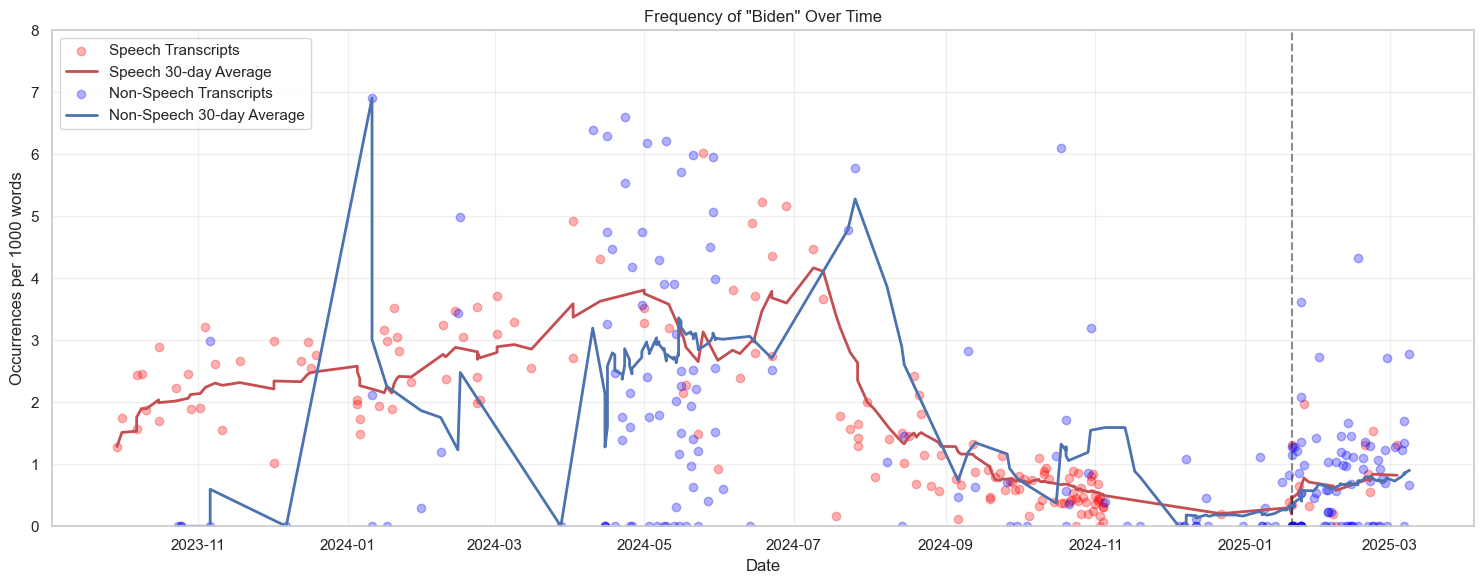

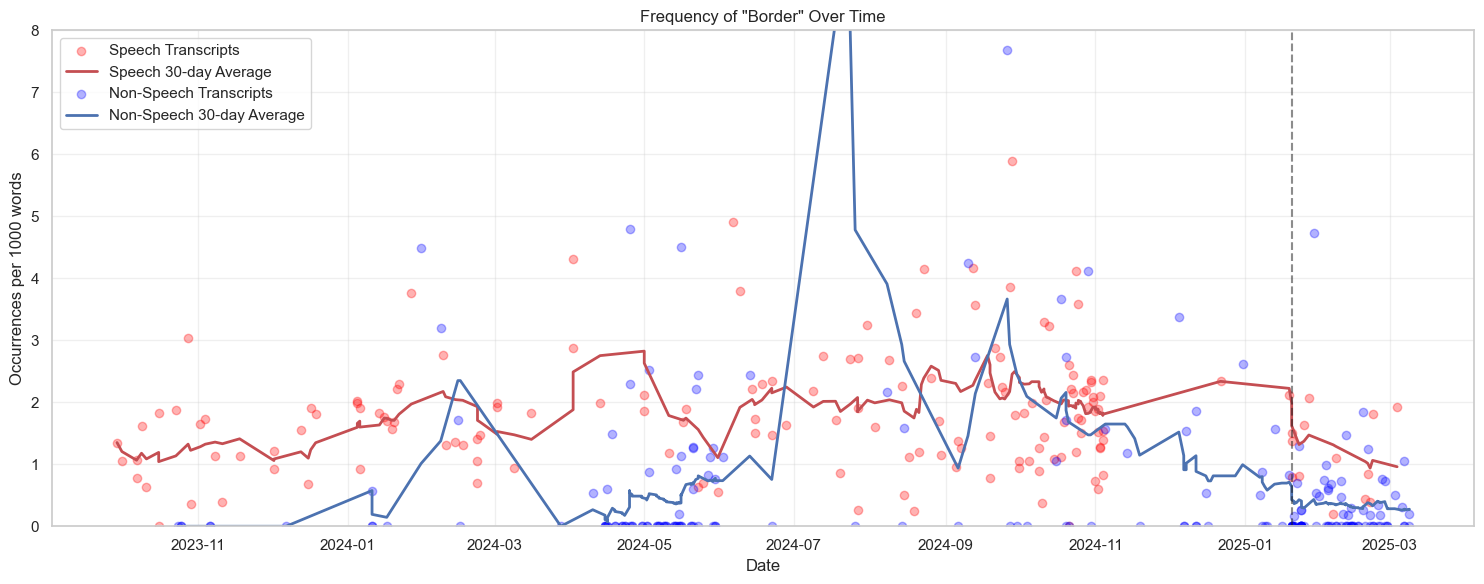

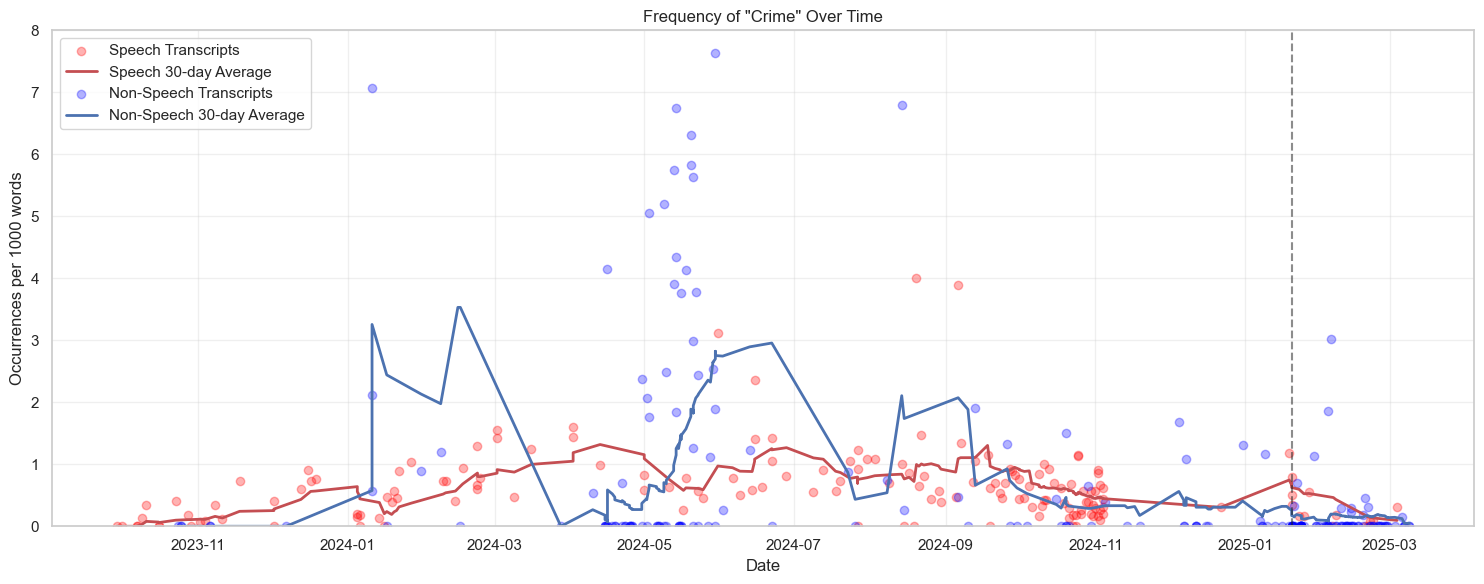

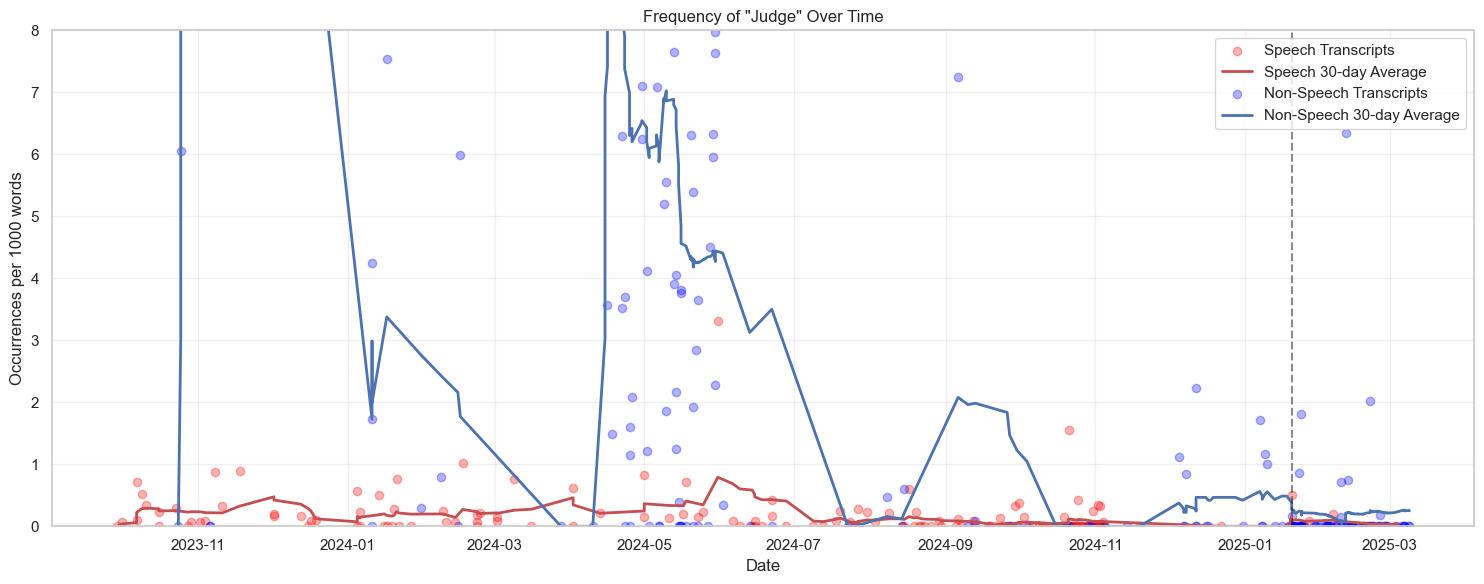

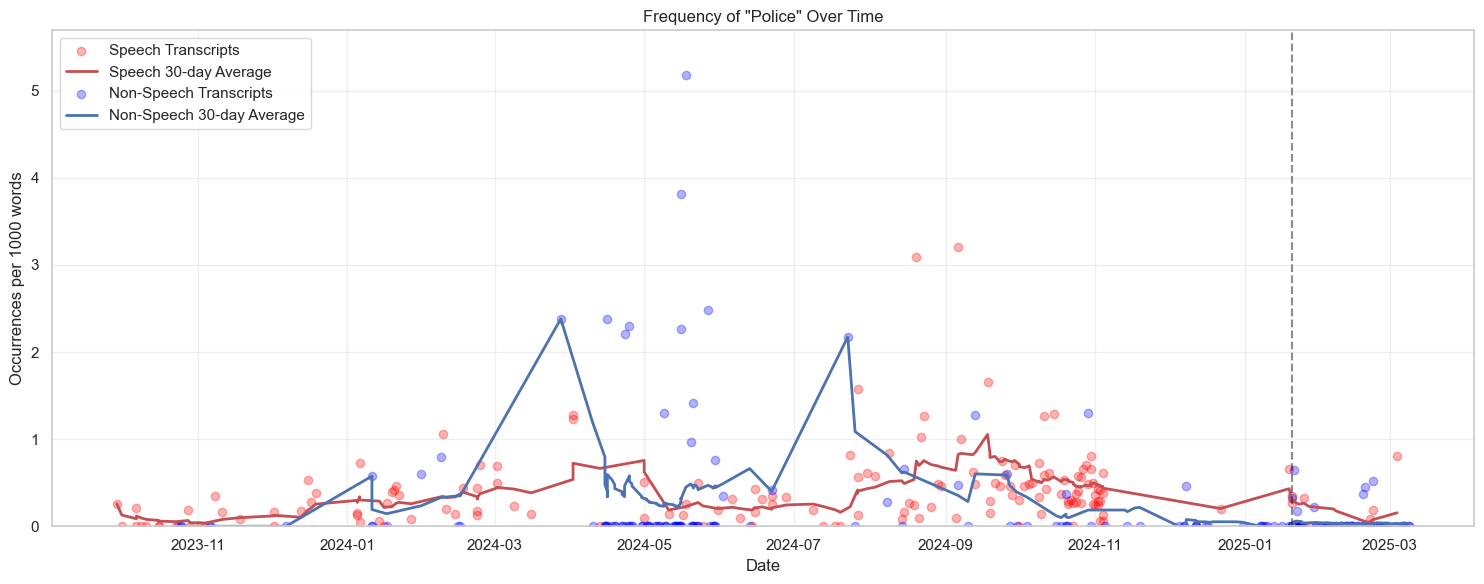

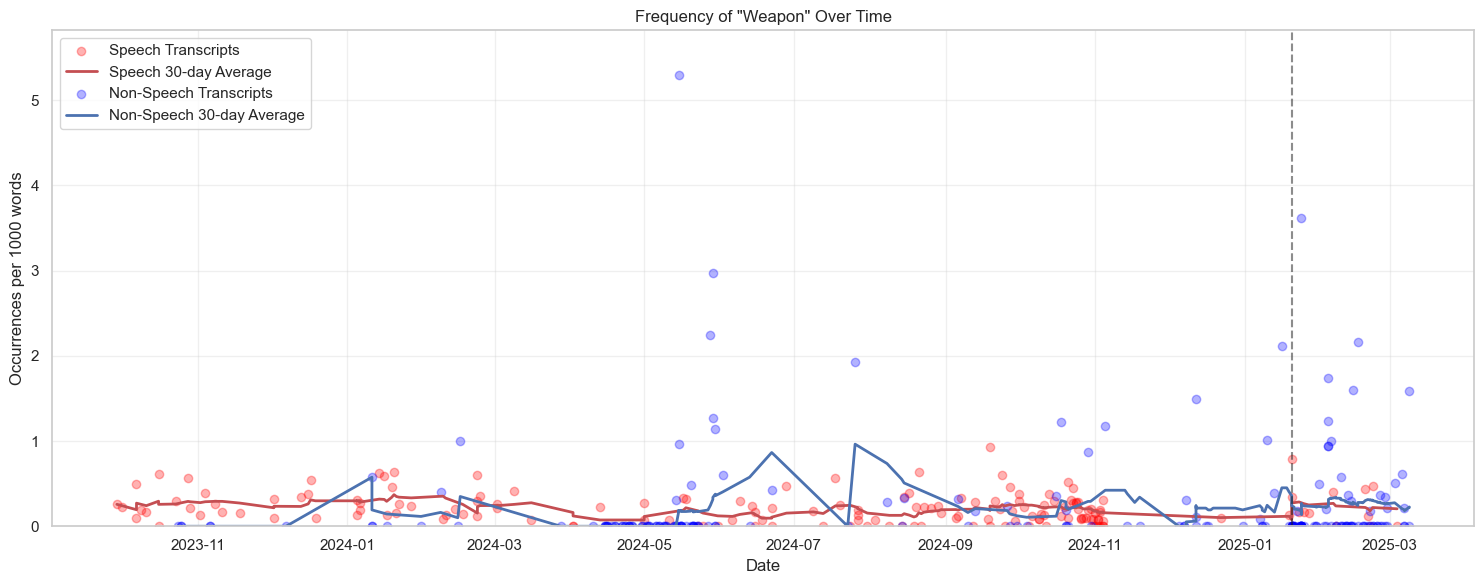

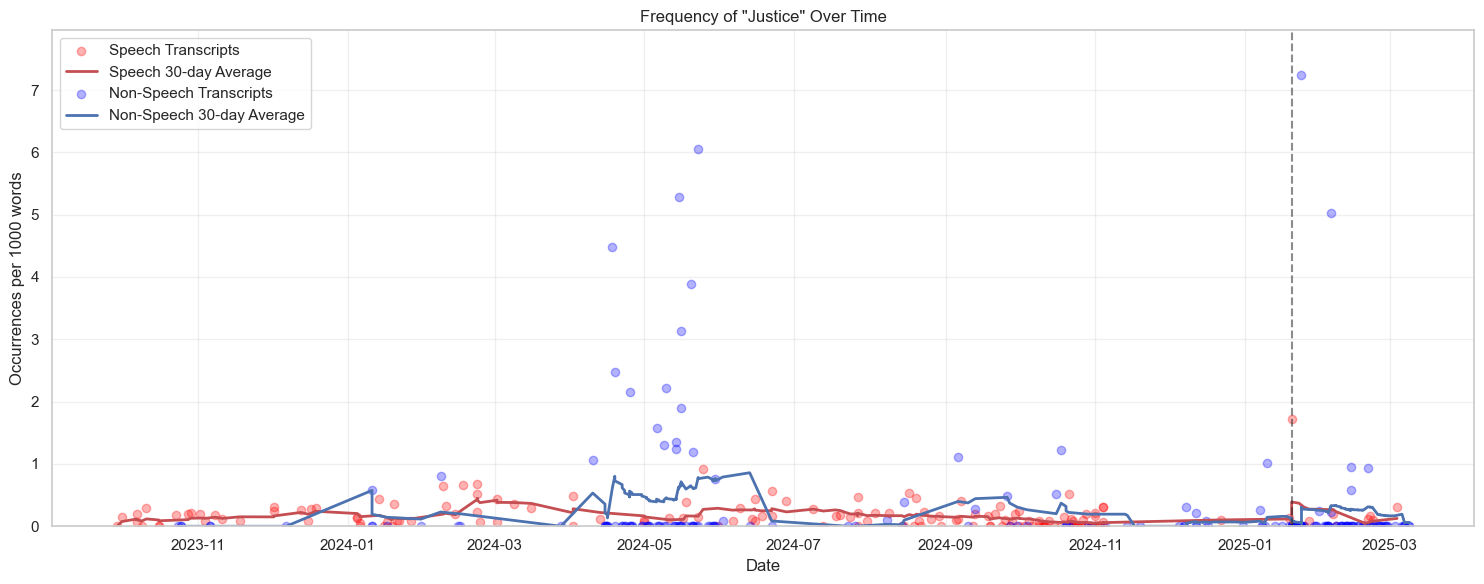

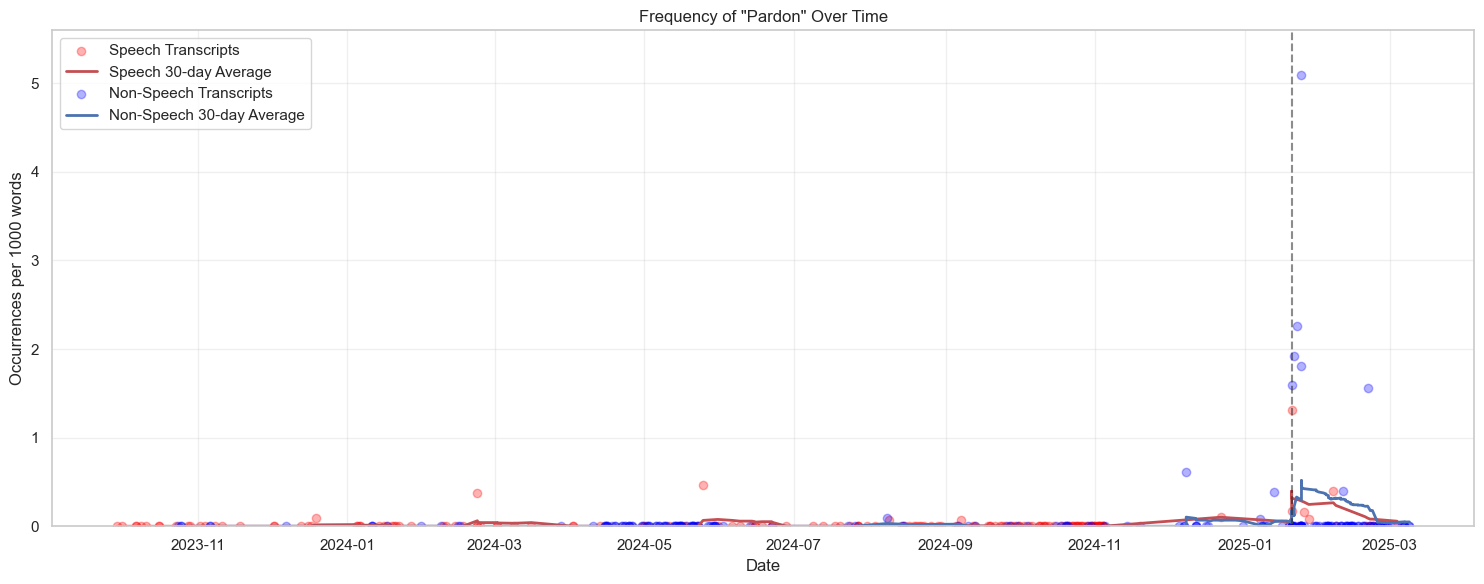

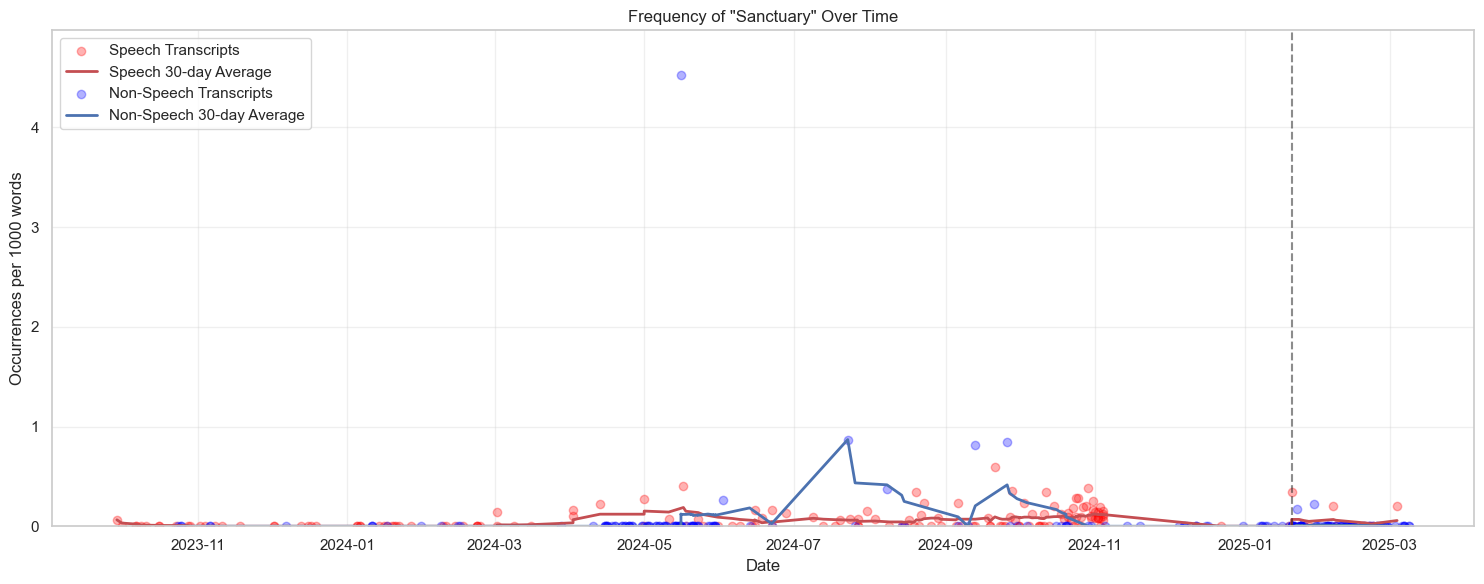

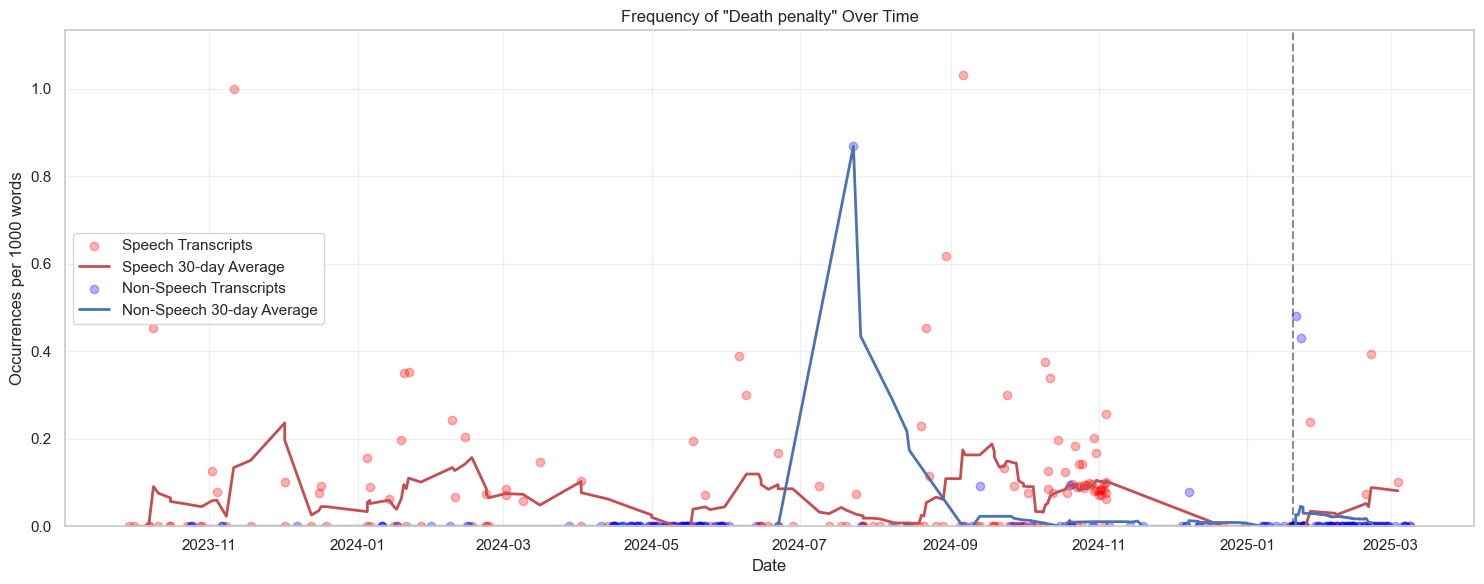

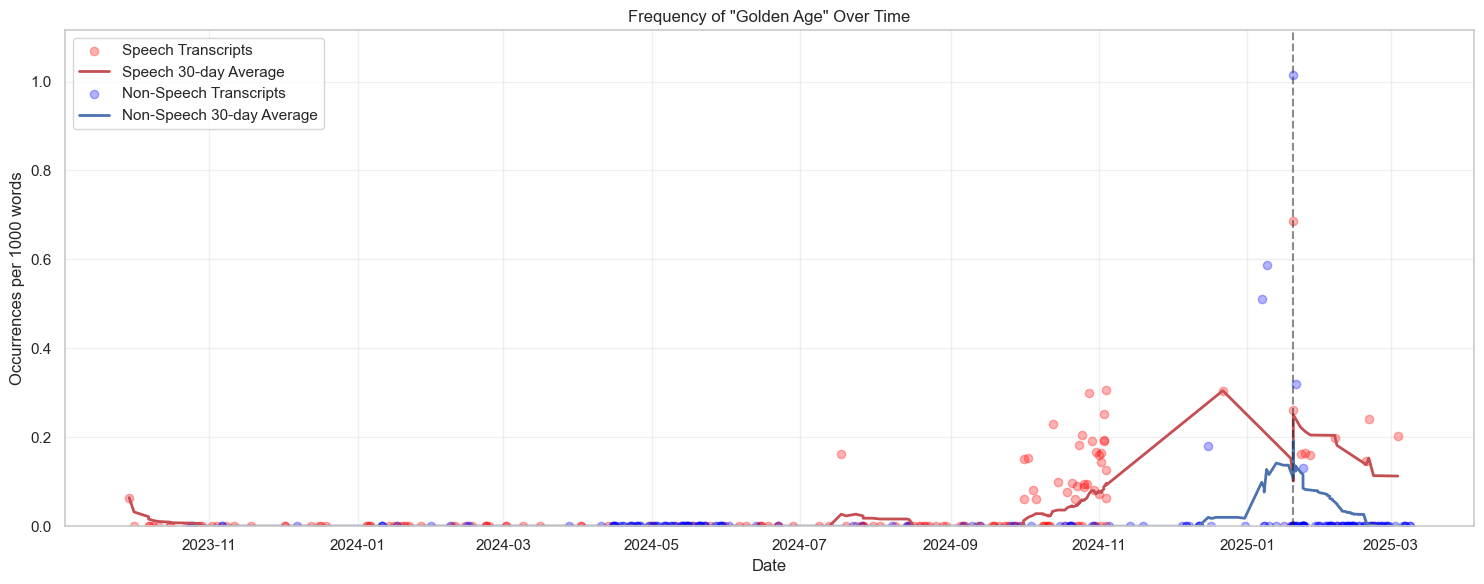

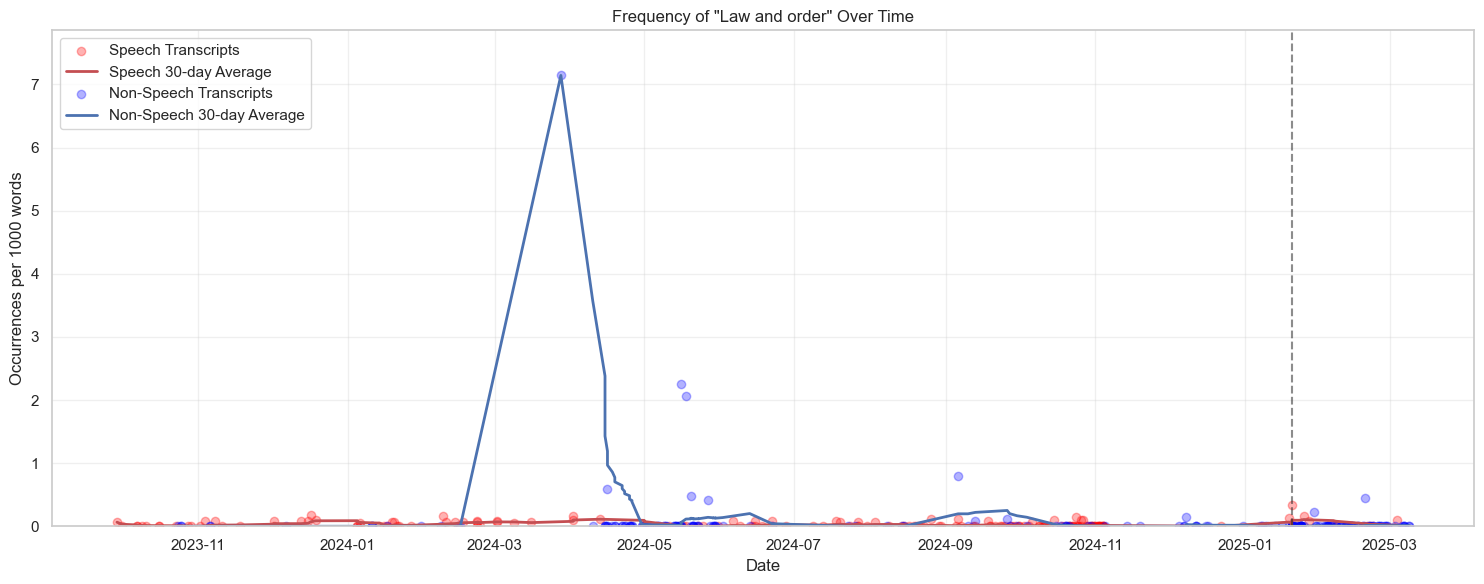

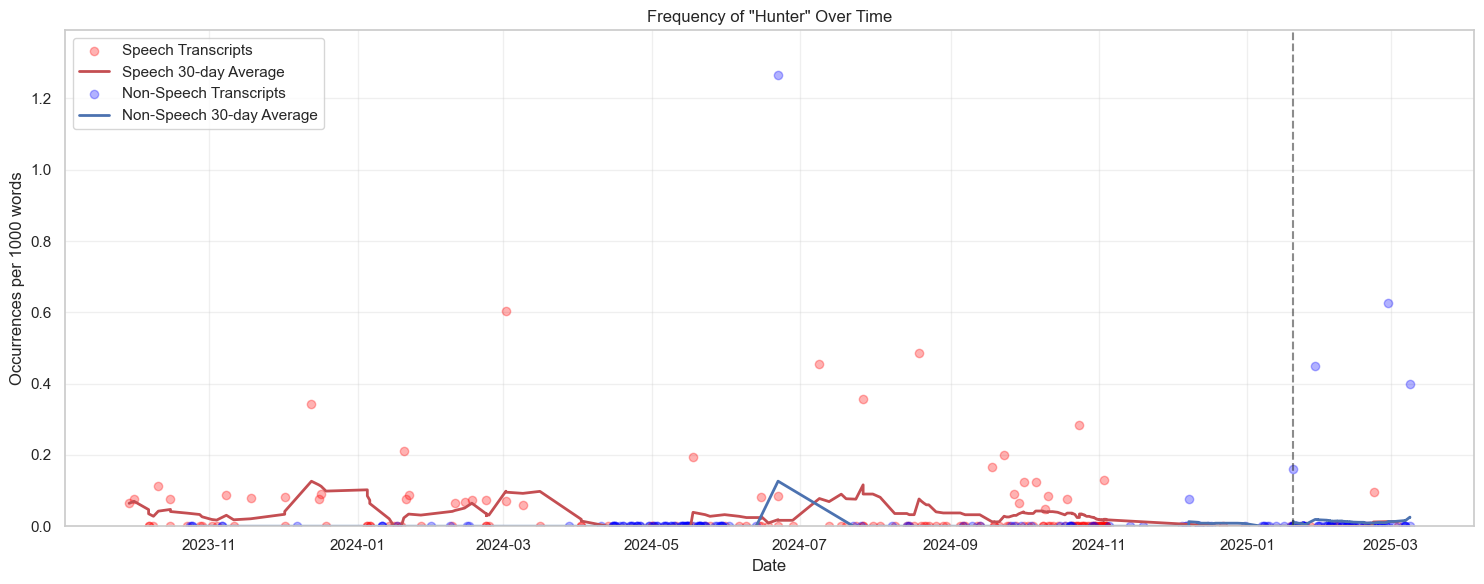

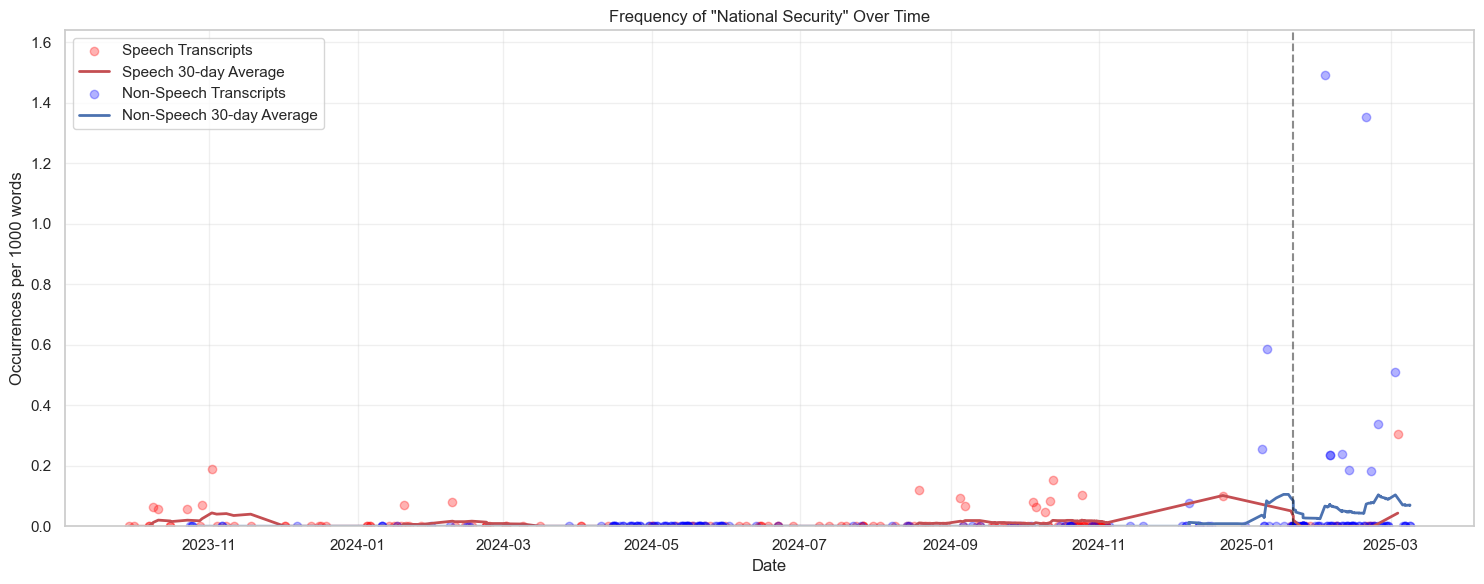

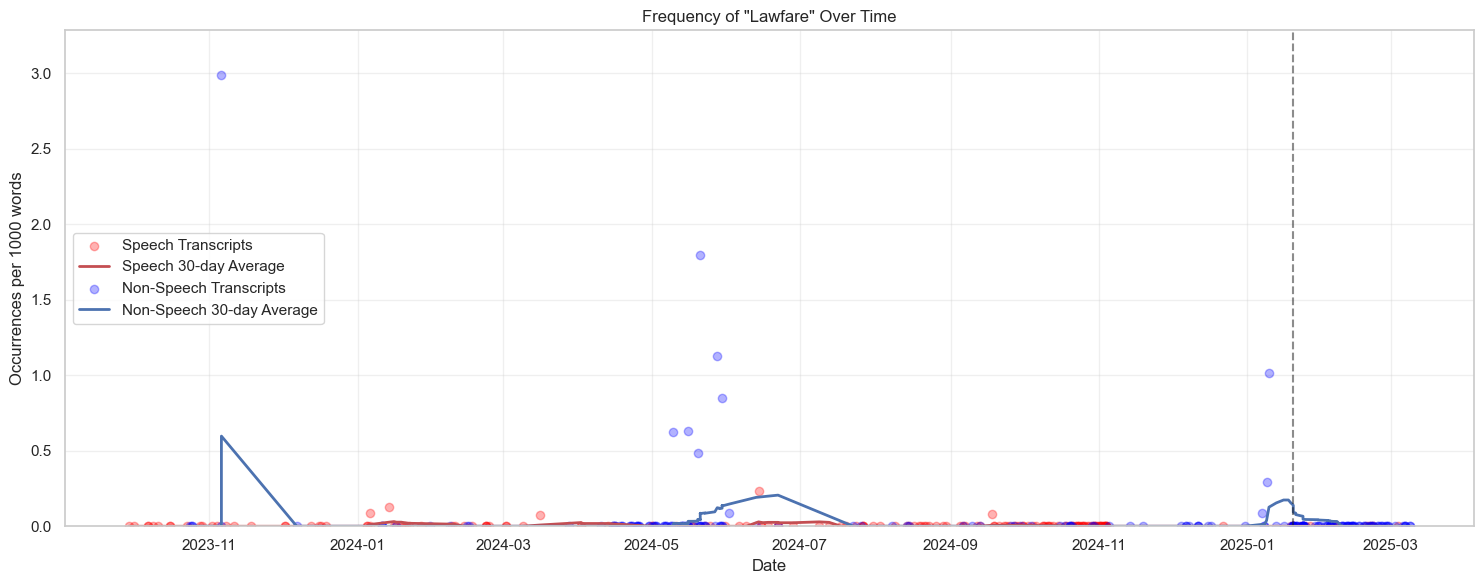

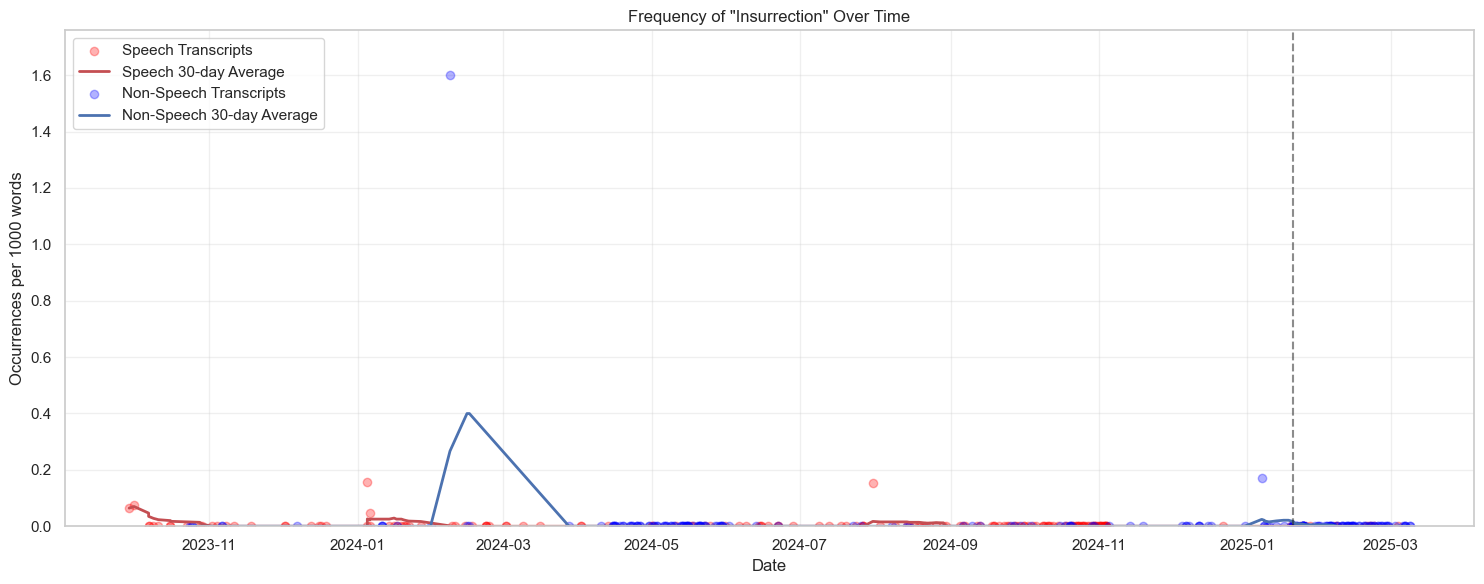

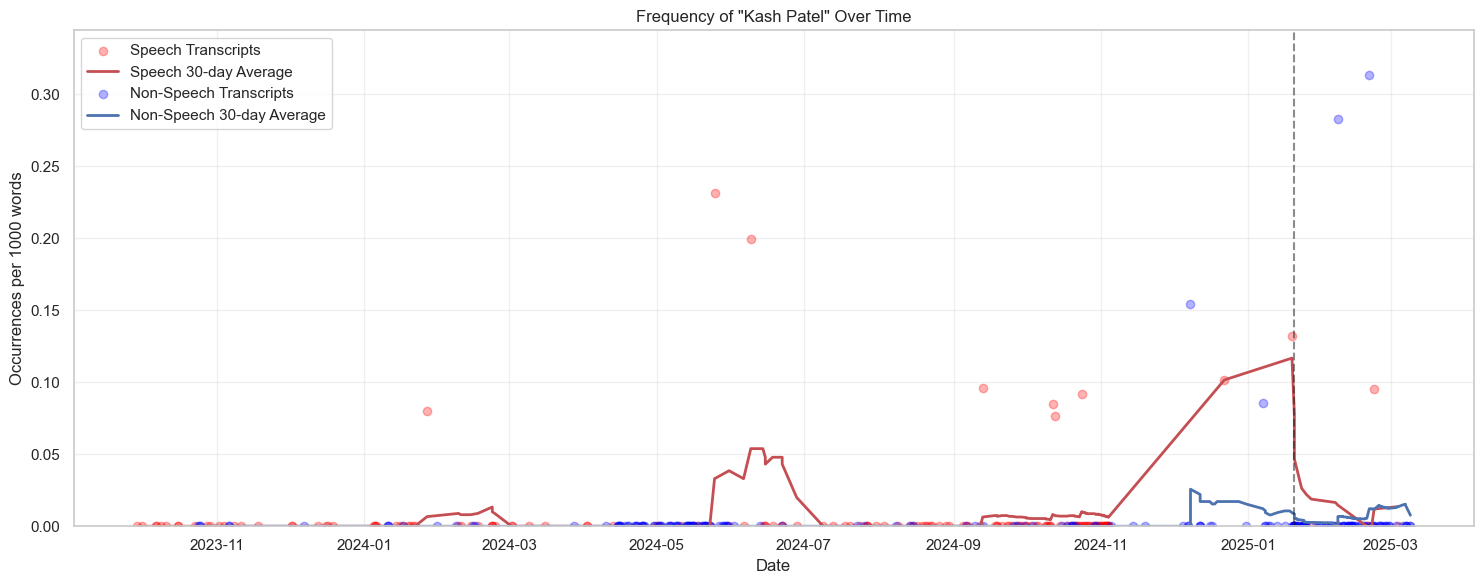

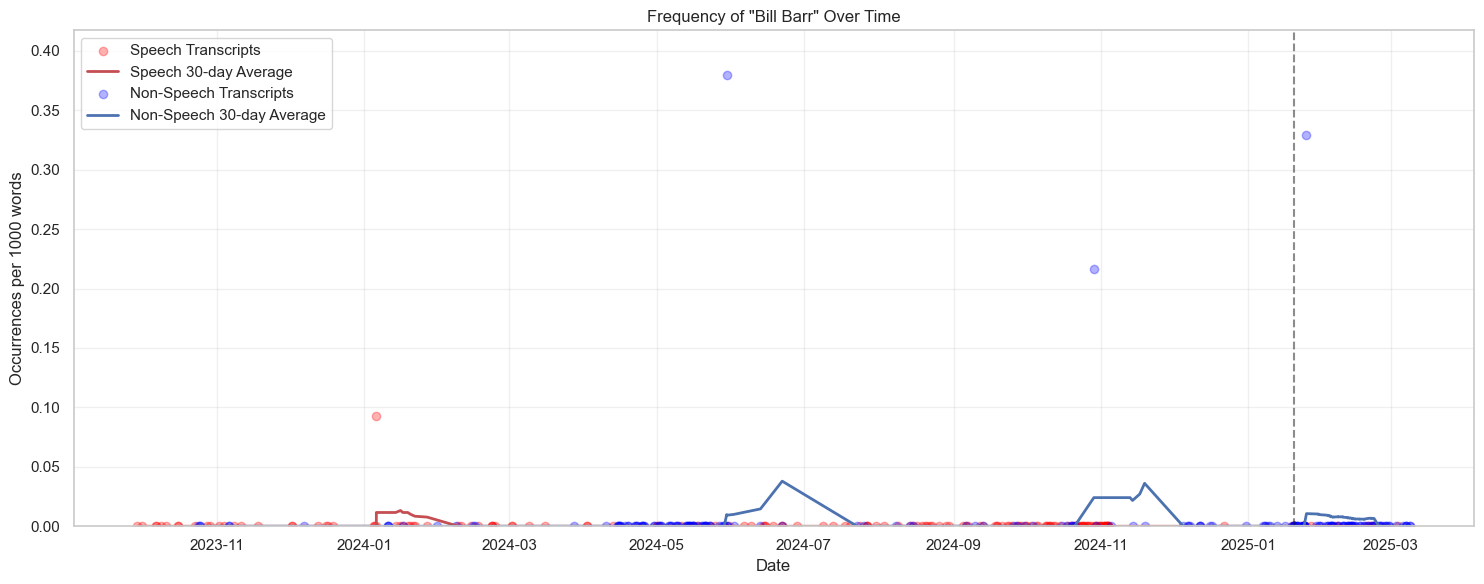

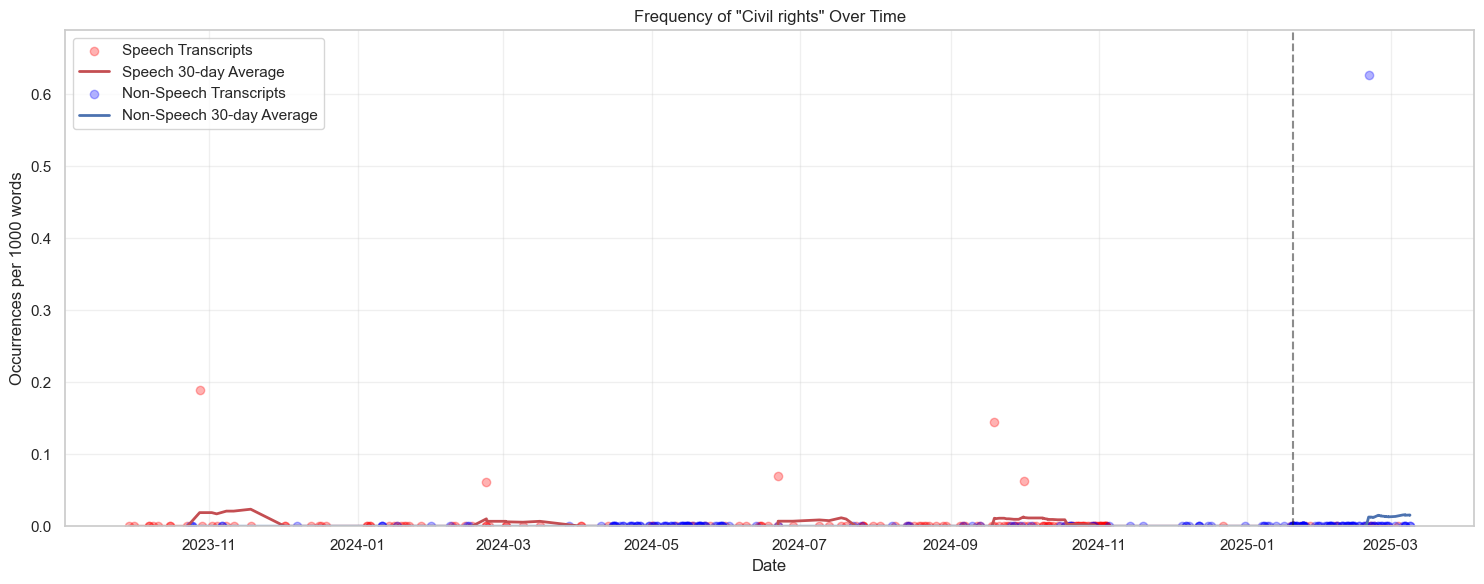

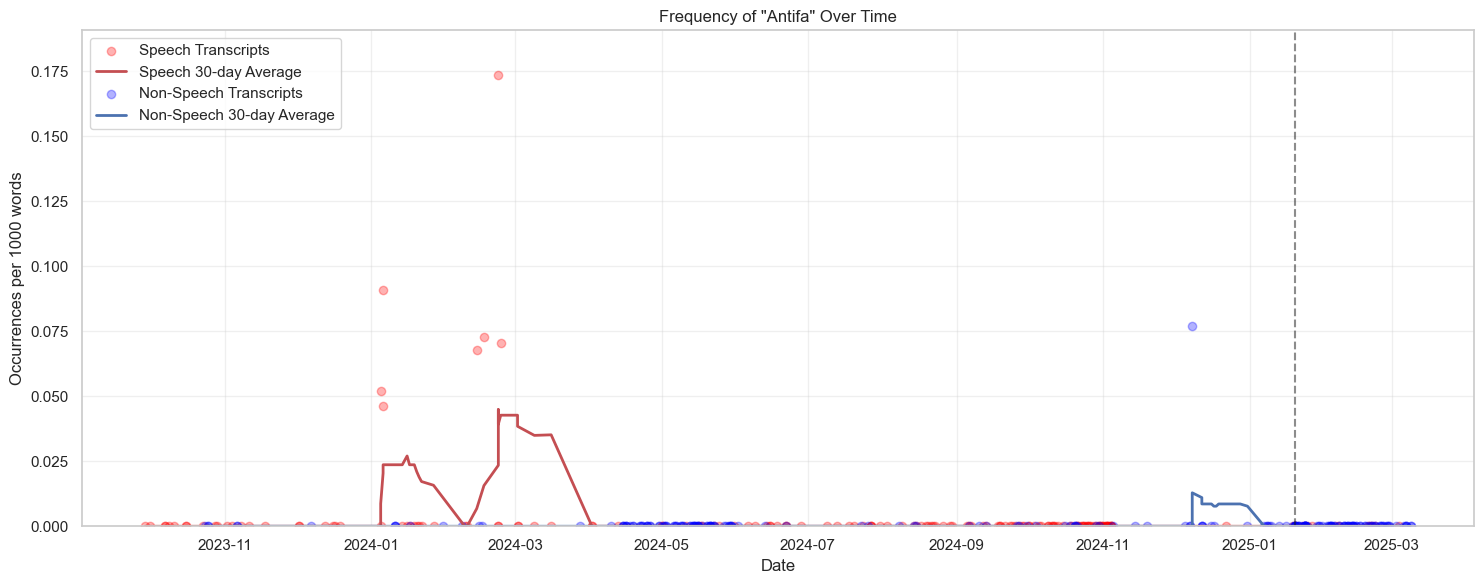

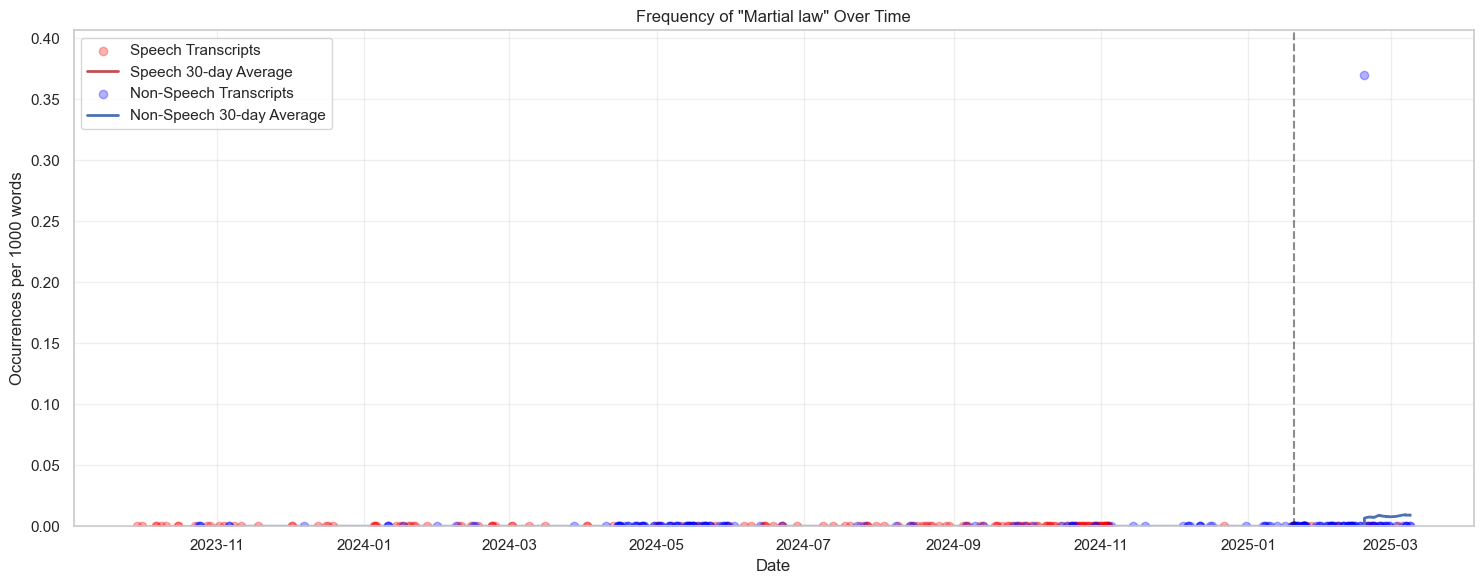

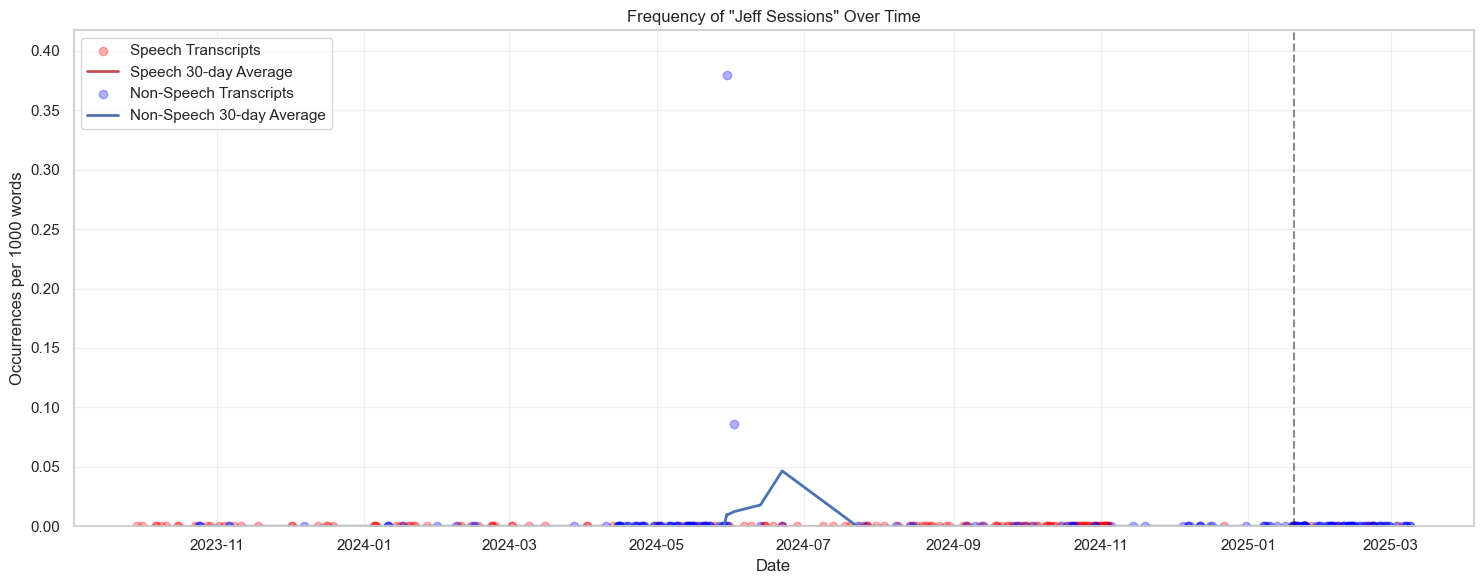

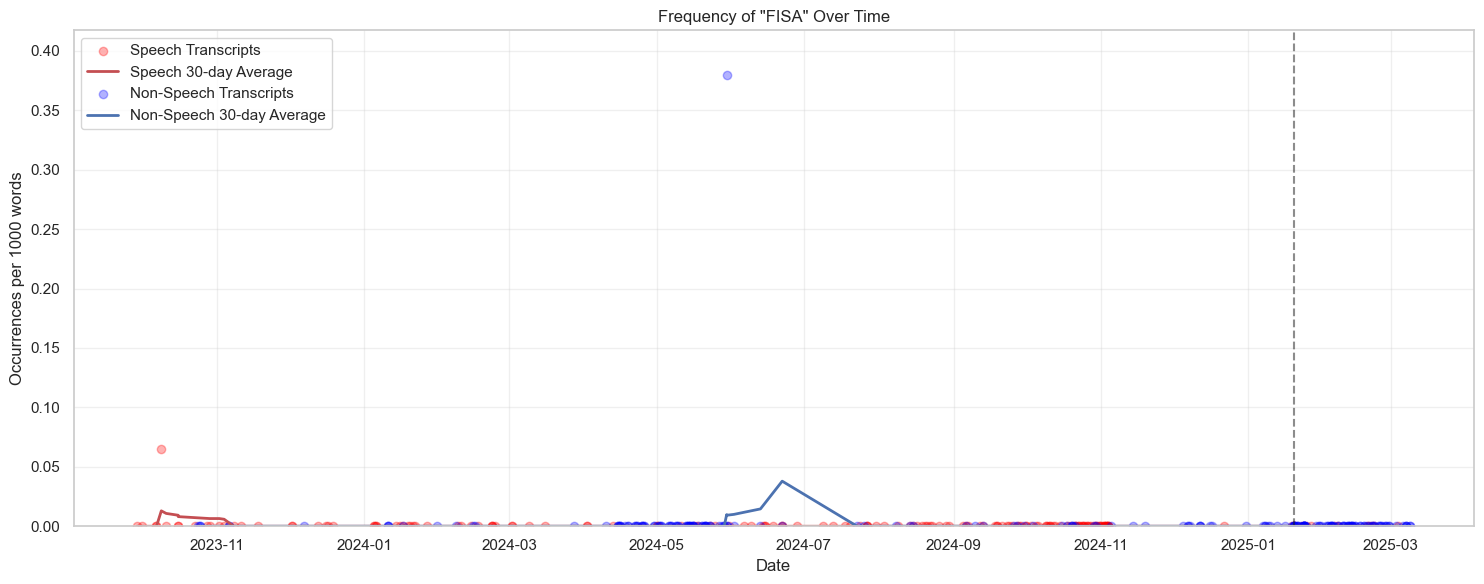

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_97764/3705365225.py:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


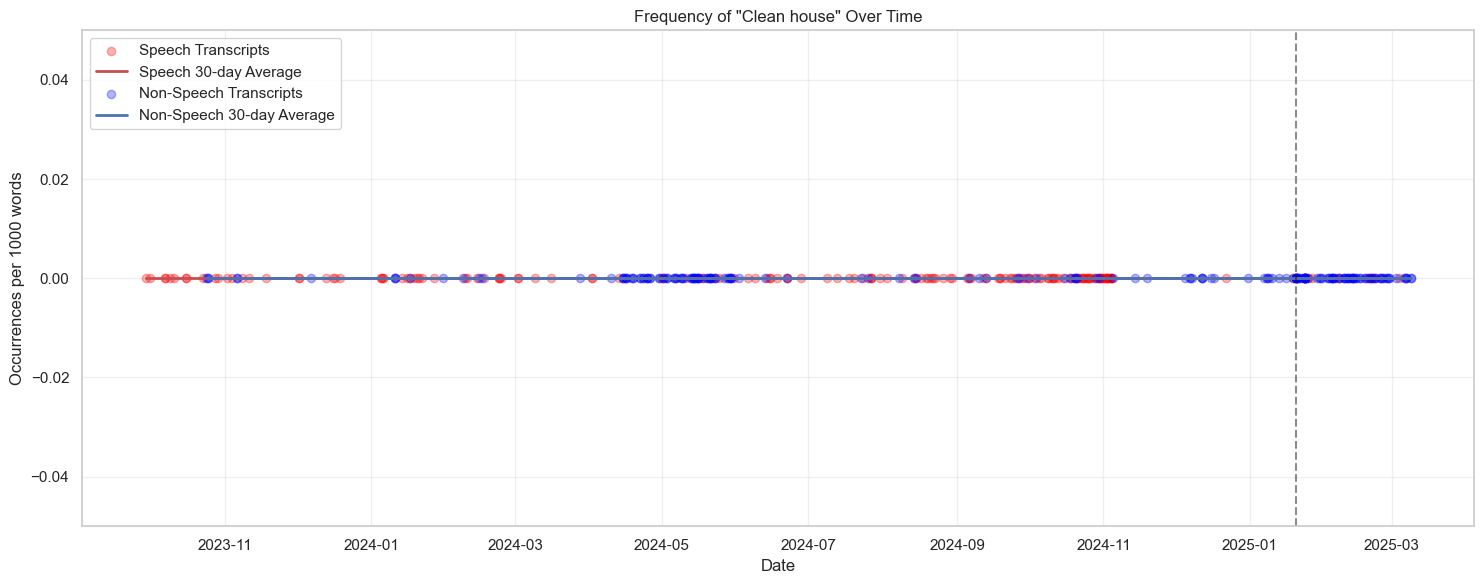

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_97764/3705365225.py:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)


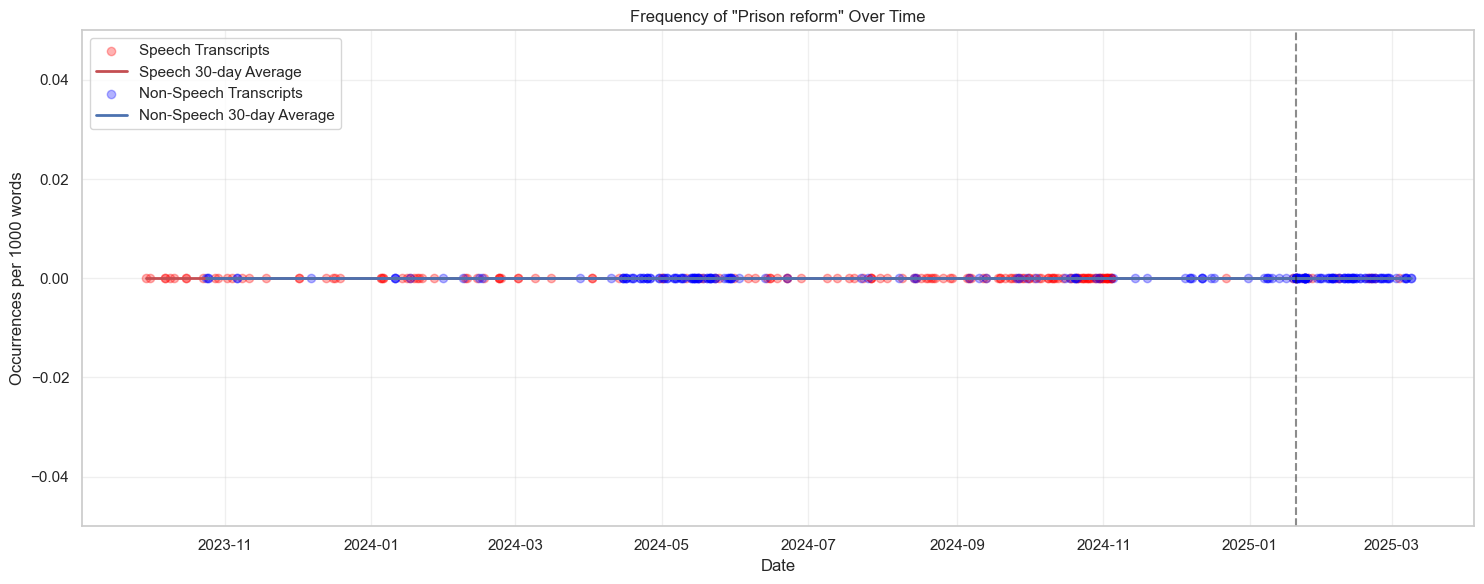

In [7]:
def plot_phrase_frequency_over_time(df_speech, df_non_speech, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for speech and non-speech"""
    plt.figure(figsize=(15, 6))
    
    # Process speech data
    df_speech = df_speech.copy()
    df_speech[f'{phrase}_freq'] = (df_speech[phrase] / df_speech['text_length']) * 1000
    speech_series = df_speech.set_index('date')[f'{phrase}_freq']
    speech_rolling = speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-speech data
    df_non_speech = df_non_speech.copy()
    df_non_speech[f'{phrase}_freq'] = (df_non_speech[phrase] / df_non_speech['text_length']) * 1000
    non_speech_series = df_non_speech.set_index('date')[f'{phrase}_freq']
    non_speech_rolling = non_speech_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot speech data
    plt.scatter(speech_series.index, speech_series.values, alpha=0.3, color='red', label='Speech Transcripts')
    plt.plot(speech_rolling.index, speech_rolling.values, 'r-', linewidth=2, label=f'Speech {window}-day Average')
    
    # Plot non-speech data
    plt.scatter(non_speech_series.index, non_speech_series.values, alpha=0.3, color='blue', label='Non-Speech Transcripts')
    plt.plot(non_speech_rolling.index, non_speech_rolling.values, 'b-', linewidth=2, label=f'Non-Speech {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_speech[f'{phrase}_freq'].max(),
        df_non_speech[f'{phrase}_freq'].max()
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    plt.show()

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    speech_freq = (df_speech[phrase].sum() / df_speech['text_length'].sum()) * 1000
    nonspeech_freq = (df_nonspeech[phrase].sum() / df_nonspeech['text_length'].sum()) * 1000
    phrase_freqs[phrase] = (speech_freq + nonspeech_freq) / 2

# Sort phrases by frequency and plot
for phrase in sorted(phrase_freqs, key=phrase_freqs.get, reverse=True):
    plot_phrase_frequency_over_time(df_speech, df_nonspeech, phrase)

## Previous State of the Unions

Relevant for tone, stable phrases and for predicting length of future SOTUs.

In [8]:
# Create a table showing phrase counts for each SOTU
sotu_counts = []

for phrase in SEARCH_PHRASES.keys():
    # Get counts for each SOTU
    counts = df_sotu[['date', phrase]].values.tolist()
    
    # Format into a row with the phrase and counts
    row = {'Phrase': phrase}
    for date, count in counts:
        year = date.year
        row[f'SOTU {year}'] = count
        
    sotu_counts.append(row)

# Convert to DataFrame and display
df_sotu_counts = pd.DataFrame(sotu_counts)
# Sort by average counts across all SOTUs
df_sotu_counts['Average'] = df_sotu_counts[[col for col in df_sotu_counts.columns if 'SOTU' in col]].mean(axis=1)
df_sotu_counts = df_sotu_counts.sort_values('Average', ascending=False)

# Display the table
display(df_sotu_counts.style.format({col: '{:.0f}' for col in df_sotu_counts.columns if 'SOTU' in col}))


,Phrase,SOTU 2017,SOTU 2018,SOTU 2019,SOTU 2020,Average
1,Border,6,5,14,9,8.500000
2,Justice,7,1,3,6,4.250000
12,Sanctuary,1,0,0,10,2.750000
0,Crime,4,2,3,1,2.500000
6,Police,1,5,0,2,2.000000
4,Weapon,1,1,1,2,1.250000
9,Judge,2,2,0,1,1.250000
20,Civil rights,2,0,1,1,1.000000
11,National Security,0,0,1,1,0.500000
16,Bill Barr,0,0,0,0,0.000000


## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [9]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1),
            'P(≥3)': poisson_ge_k(expected, 3),
            'P(≥4)': poisson_ge_k(expected, 4),
            'P(≥5)': poisson_ge_k(expected, 5),
            'P(≥15)': poisson_ge_k(expected, 15)
        })
    
    return pd.DataFrame(predictions)

# Use SOTU average length for predictions
avg_sotu_length = df_sotu['text_length'].mean()

# Calculate predictions from different data sources
predictions_all = calculate_poisson_predictions(df, avg_sotu_length)
predictions_speeches = calculate_poisson_predictions(df_speech, avg_sotu_length)
predictions_post_all = calculate_poisson_predictions(pd.concat([df_nonspeech_post, df_speech_post]), avg_sotu_length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥3)'] = formatted['P(≥3)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥4)'] = formatted['P(≥4)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥5)'] = formatted['P(≥5)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥15)'] = formatted['P(≥15)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all, 'all'))

print("\nPredictions based on all speeches:")
display(format_prediction_table(predictions_speeches, 'post-inauguration-speeches'))

print("\nPredictions based on all post-inauguration appearances:")
display(format_prediction_table(predictions_post_all, 'post-inauguration-all'))

Predictions based on all appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
1,Border,8.81,100.0%,99.0%,98.0%,94.0%,4.0%,1.62,3893
8,Biden,8.31,100.0%,99.0%,97.0%,92.0%,2.0%,1.53,3673
0,Crime,3.23,96.0%,63.0%,40.0%,22.0%,0.0%,0.59,1426
6,Police,1.88,85.0%,29.0%,12.0%,4.0%,0.0%,0.35,830
9,Judge,1.58,79.0%,21.0%,8.0%,2.0%,0.0%,0.29,699
4,Weapon,1.21,70.0%,12.0%,3.0%,1.0%,0.0%,0.22,534
2,Justice,0.90,59.0%,6.0%,1.0%,0.0%,0.0%,0.17,398
10,Death penalty,0.41,34.0%,1.0%,0.0%,0.0%,0.0%,0.08,181
12,Sanctuary,0.36,30.0%,1.0%,0.0%,0.0%,0.0%,0.07,157
7,Hunter,0.19,17.0%,0.0%,0.0%,0.0%,0.0%,0.03,82



Predictions based on all speeches:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
1,Border,9.65,100.0%,100.0%,99.0%,96.0%,7.0%,1.78,3373
8,Biden,8.91,100.0%,99.0%,98.0%,94.0%,4.0%,1.64,3113
0,Crime,3.23,96.0%,63.0%,40.0%,22.0%,0.0%,0.60,1129
6,Police,2.05,87.0%,34.0%,15.0%,6.0%,0.0%,0.38,716
4,Weapon,1.14,68.0%,11.0%,3.0%,1.0%,0.0%,0.21,397
9,Judge,0.85,57.0%,5.0%,1.0%,0.0%,0.0%,0.16,297
2,Justice,0.83,56.0%,5.0%,1.0%,0.0%,0.0%,0.15,289
10,Death penalty,0.49,39.0%,1.0%,0.0%,0.0%,0.0%,0.09,172
12,Sanctuary,0.33,28.0%,0.0%,0.0%,0.0%,0.0%,0.06,115
7,Hunter,0.20,18.0%,0.0%,0.0%,0.0%,0.0%,0.04,70



Predictions based on all post-inauguration appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
8,Biden,5.17,99.0%,89.0%,76.0%,59.0%,0.0%,0.95,316
1,Border,3.58,97.0%,69.0%,48.0%,29.0%,0.0%,0.66,219
4,Weapon,1.39,75.0%,16.0%,5.0%,1.0%,0.0%,0.26,85
13,Pardon,0.90,59.0%,6.0%,1.0%,0.0%,0.0%,0.17,55
0,Crime,0.87,58.0%,6.0%,1.0%,0.0%,0.0%,0.16,53
9,Judge,0.69,50.0%,3.0%,1.0%,0.0%,0.0%,0.13,42
2,Justice,0.51,40.0%,1.0%,0.0%,0.0%,0.0%,0.09,31
6,Police,0.44,36.0%,1.0%,0.0%,0.0%,0.0%,0.08,27
14,Golden Age,0.31,27.0%,0.0%,0.0%,0.0%,0.0%,0.06,19
11,National Security,0.26,23.0%,0.0%,0.0%,0.0%,0.0%,0.05,16


## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

Negative Binomial Predictions based on all appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15)
1,Border,8.81,1.62,56.83,95.1%,80.9%,73.4%,66.0%,18.5%
8,Biden,8.31,0.61,120.89,80.7%,61.3%,54.6%,48.9%,18.9%
0,Crime,3.23,0.14,76.36,36.3%,22.8%,19.6%,17.1%,6.6%
6,Police,1.88,0.45,9.64,52.4%,24.9%,18.1%,13.5%,1.0%
9,Judge,1.58,0.10,531.69,24.6%,13.8%,11.4%,9.7%,2.9%
4,Weapon,1.21,0.24,7.19,35.3%,15.4%,11.1%,8.3%,0.7%
2,Justice,0.90,0.10,17.50,20.6%,9.9%,7.7%,6.1%,1.1%
10,Death penalty,0.41,7.16,0.43,32.9%,1.1%,0.1%,0.0%,0.0%
12,Sanctuary,0.36,0.10,2.15,14.1%,4.5%,2.9%,2.0%,0.1%
14,Golden Age,0.20,0.62,0.26,15.6%,0.6%,0.1%,0.0%,0.0%


Negative Binomial Predictions based on all speeches:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15)
1,Border,9.65,3.71,34.72,99.1%,92.9%,87.5%,81.0%,18.4%
8,Biden,8.91,2.00,48.48,96.6%,84.4%,77.1%,69.6%,18.0%
0,Crime,3.23,1.45,10.43,81.7%,47.9%,35.7%,26.2%,0.9%
6,Police,2.05,1.08,5.91,68.4%,30.6%,20.3%,13.5%,0.2%
4,Weapon,1.14,100.00,0.96,67.7%,10.8%,2.9%,0.7%,0.0%
9,Judge,0.85,0.27,3.49,32.0%,11.2%,7.3%,4.9%,0.2%
2,Justice,0.83,1.51,1.28,48.3%,8.4%,3.3%,1.3%,0.0%
10,Death penalty,0.49,1.33,0.67,34.2%,3.1%,0.9%,0.3%,0.0%
12,Sanctuary,0.33,100.00,0.32,28.0%,0.5%,0.0%,0.0%,0.0%
7,Hunter,0.20,1.15,0.24,16.9%,0.4%,0.1%,0.0%,0.0%


Negative Binomial Predictions based on all appearances post inauguration:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15)
8,Biden,5.17,1.71,20.82,90.7%,66.7%,55.5%,45.5%,4.5%
1,Border,3.58,1.16,14.65,80.5%,49.4%,38.3%,29.6%,2.0%
4,Weapon,1.39,0.25,9.15,37.5%,17.3%,12.8%,9.7%,1.0%
13,Pardon,0.90,0.10,13.74,20.6%,9.9%,7.6%,6.1%,1.1%
0,Crime,0.87,0.19,4.86,27.7%,11.1%,7.8%,5.7%,0.4%
9,Judge,0.69,0.10,15.63,18.6%,8.1%,6.0%,4.6%,0.6%
2,Justice,0.51,0.10,26.02,16.5%,6.3%,4.5%,3.2%,0.3%
6,Police,0.44,0.98,0.64,30.5%,2.9%,0.9%,0.3%,0.0%
14,Golden Age,0.31,0.36,0.58,20.0%,2.6%,1.0%,0.4%,0.0%
11,National Security,0.26,0.10,1.46,12.1%,3.2%,1.9%,1.2%,0.0%



Model Comparison (Negative Binomial vs Poisson):


,Phrase,Expected,Poisson P(≥1),NB P(≥1),Δ P(≥1),Poisson P(≥5),NB P(≥5),Δ P(≥5),Dispersion (r),Sample Variance
13,Pardon,0.527,41.0%,4.8%,-36.199,0.0%,0.0%,0.008,0.100,0.410
14,Golden Age,0.738,52.2%,16.9%,-35.309,0.1%,0.0%,-0.085,0.995,0.245
11,National Security,0.158,14.6%,6.4%,-8.258,0.0%,0.0%,-0.000,100.000,0.042
10,Death penalty,0.527,41.0%,34.2%,-6.751,0.0%,0.3%,0.240,1.332,0.674
3,Law and order,0.211,19.0%,12.3%,-6.684,0.0%,0.0%,-0.000,100.000,0.074
2,Justice,0.738,52.2%,48.3%,-3.896,0.1%,1.3%,1.177,1.512,1.279
8,Biden,4.638,99.0%,96.6%,-2.383,49.4%,69.6%,20.259,2.004,48.478
5,Kash Patel,0.053,5.1%,3.1%,-2.036,0.0%,0.0%,-0.000,100.000,0.029
4,Weapon,1.159,68.6%,67.7%,-0.959,0.7%,0.7%,-0.018,100.000,0.961
1,Border,6.324,99.8%,99.1%,-0.681,75.6%,81.0%,5.355,3.714,34.722



Distribution comparison for Border (r = 3.71):


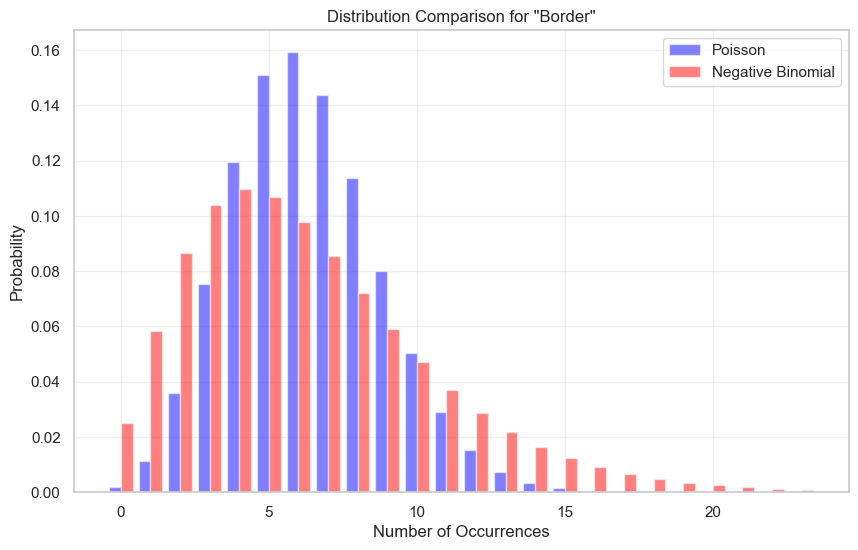

In [10]:

def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihoods using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Dispersion (r)': r,
            'Sample Variance': sample_variance,
            'P(≥1)': nb_ge_k(r, p, 1),
            'P(≥3)': nb_ge_k(r, p, 3),
            'P(≥4)': nb_ge_k(r, p, 4),
            'P(≥5)': nb_ge_k(r, p, 5),
            'P(≥15)': nb_ge_k(r, p, 15)
        })
    
    return pd.DataFrame(predictions)


def format_prediction_table(df):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(3)
    
    # Format probability columns as percentages
    prob_columns = ['P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)']
    for col in prob_columns:
        formatted[col] = formatted[col].map('{:.1%}'.format)
    
    # Round other numeric columns
    formatted['Expected'] = formatted['Expected'].round(2)
    if 'Dispersion (r)' in formatted.columns:
        formatted['Dispersion (r)'] = formatted['Dispersion (r)'].round(2)
        formatted['Sample Variance'] = formatted['Sample Variance'].round(2)
    
    return formatted.sort_values('Expected', ascending=False)

def compare_models(poisson_df, nb_df):
    """Compare Poisson and Negative Binomial predictions"""
    comparison = pd.DataFrame()
    comparison['Phrase'] = poisson_df['Phrase']
    comparison['Expected'] = poisson_df['Expected']
    
    # Convert percentage strings back to floats for calculations
    for k in [1, 5]:
        # Get raw probability values directly
        comparison[f'Poisson P(≥{k})'] = poisson_df[f'P(≥{k})'].astype(float)
        comparison[f'NB P(≥{k})'] = nb_df[f'P(≥{k})'].astype(float)
        comparison[f'Δ P(≥{k})'] = (comparison[f'NB P(≥{k})'] - comparison[f'Poisson P(≥{k})']) * 100
    
    comparison['Dispersion (r)'] = nb_df['Dispersion (r)']
    comparison['Sample Variance'] = nb_df['Sample Variance']
    
    # Format probability columns as percentages
    for col in comparison.columns:
        if 'P(≥' in col and 'Δ' not in col:
            comparison[col] = comparison[col].map('{:.1%}'.format)
    
    return comparison.round(3).sort_values('Δ P(≥1)', ascending=True)

def plot_distribution_comparison(phrase, poisson_df, nb_df, max_k=10):
    """Plot comparison of Poisson and Negative Binomial distributions"""
    phrase_data = poisson_df[poisson_df['Phrase'] == phrase].iloc[0]
    nb_data = nb_df[nb_df['Phrase'] == phrase].iloc[0]
    
    lambda_ = phrase_data['Expected']
    r = nb_data['Dispersion (r)']
    p = r/(r + lambda_)
    
    k = np.arange(0, max_k+1)
    poisson_pmf = stats.poisson.pmf(k, lambda_)
    nb_pmf = stats.nbinom.pmf(k, r, p)
    
    plt.figure(figsize=(10, 6))
    plt.bar(k-0.2, poisson_pmf, width=0.4, alpha=0.5, label='Poisson', color='blue')
    plt.bar(k+0.2, nb_pmf, width=0.4, alpha=0.5, label='Negative Binomial', color='red')
    plt.title(f'Distribution Comparison for "{phrase}"')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Calculate predictions using both models
avg_speech_length = df_sotu['text_length'].mean()

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on all speeches:")
nb_predictions = calculate_negative_binomial_predictions(df_speech, avg_speech_length)
display(format_prediction_table(nb_predictions))


print("Negative Binomial Predictions based on all appearances post inauguration:")
nb_predictions_all = calculate_negative_binomial_predictions(df_post, avg_speech_length)
display(format_prediction_table(nb_predictions_all))

poisson_predictions = calculate_poisson_predictions(df_speech_post, avg_speech_length)

print("\nModel Comparison (Negative Binomial vs Poisson):")
display(compare_models(poisson_predictions, nb_predictions))

# Plot distributions for most overdispersed phrases
most_overdispersed = nb_predictions[nb_predictions['Phrase'].isin(['Border', 'America', 'God', 'January 6', 'MAGA', 'LA', 'Rigged', 'Hell'])]
for _, row in most_overdispersed.iterrows():
    # Get parameters for both distributions
    phrase_data = poisson_predictions[poisson_predictions['Phrase'] == row['Phrase']].iloc[0]
    lambda_ = phrase_data['Expected']
    r = row['Dispersion (r)']
    p = r/(r + lambda_)
    
    # Find where probability becomes negligible (< 0.1%)
    k = 0
    while stats.nbinom.pmf(k, r, p) > 0.001 or stats.poisson.pmf(k, lambda_) > 0.001:
        k += 1
    
    # Ensure minimum k of 30 for 'America' to show full distribution
    if row['Phrase'] == 'America':
        k = max(k, 60)
    
    print(f"\nDistribution comparison for {row['Phrase']} (r = {row['Dispersion (r)']:.2f}):")
    plot_distribution_comparison(row['Phrase'], poisson_predictions, nb_predictions, max_k=k)

## Recent Usage in context

In [11]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df_speech, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Crime' ===

Date: 2025-03-04 (speech)
Context: ...ud, nothing I can do. I could find a cure to the most devastating disease, a disease that would wipe out entire nations, or announce the answers to the greatest economy in history, or the stoppage of crime to the lowest levels ever recorded and these people sitting right here, will not clap, will not stand and certainly will not cheer for these astronomical achievements.

They won't do it, no matter wh...

Date: 2025-03-04 (speech)
Context: ...ghter, her precious Jocelyn, walked to a nearby convenience store. She was kidnaped, tied up, assaulted for two hours under a bridge, and horrifically murdered. Arrested and charged with this heinous crime are two illegal alien monsters from Venezuela released into America by the last administration through their ridiculous open border.

The death of this beautiful 12 year old girl and the agony of her...

Date: 2025-03-04 (speech)
Context: ...gned an executive order requirin

In [12]:
get_recent_contexts(df, 'Trans', 20)

KeyError: 'Trans'

## Per-Speech Frequencies


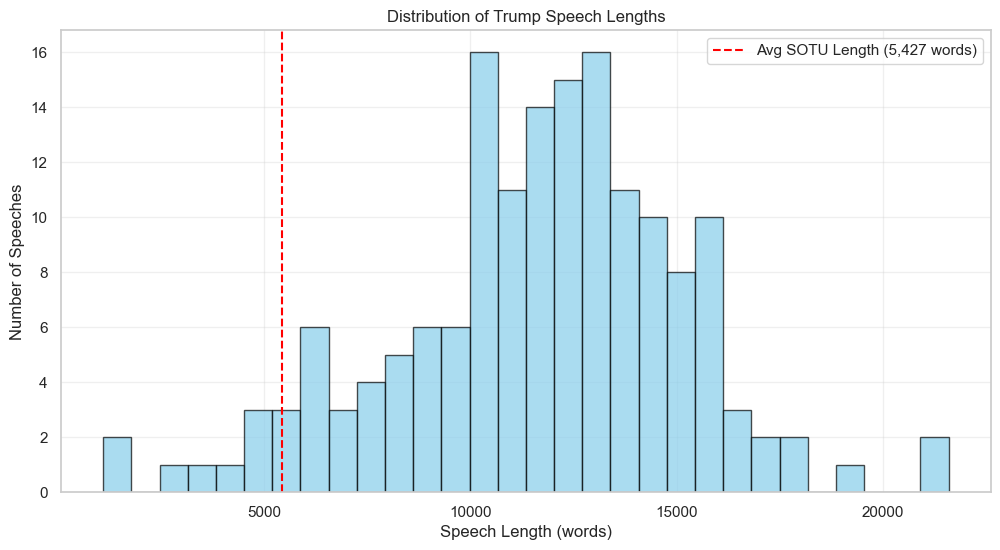

In [12]:
sotu_mean_length = df_sotu['text_length'].mean()

# Plot distribution of speech lengths with SOTU average marked
plt.figure(figsize=(12, 6))
plt.hist(df_speech['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=sotu_mean_length, color='red', linestyle='--', label=f'Avg SOTU Length ({int(sotu_mean_length):,} words)')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Trump Speech Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
# Find and display the 5 shortest speeches with their full text
shortest_speeches = df_speech.nsmallest(5, 'text_length')

print("5 Shortest Speeches:")
for _, speech in shortest_speeches.iterrows():
    print("=" * 80)
    print(f"File: {speech['file']}")
    print(f"Date: {speech['date'].strftime('%Y-%m-%d')}")
    print(f"Category: {speech['category']}")
    print(f"Length: {speech['text_length']:,} words")
    print("-" * 40)
    print(speech['text'])
    print()




5 Shortest Speeches:
File: 2024-07-13_donald_trump_holds_a_political_rally_in_butler_pennsylvania.txt
Date: 2024-07-13
Category: speech
Length: 1,093 words
----------------------------------------
This is a big crowd. This is a big, big, beautiful crowd. I wish the fake news back there would, uh, show it. I wish they'd spin their cameras and show it because nobody would believe it. You know, the other day, Biden was saying, "I get big crowds," meaning him, he gets big crowds.

He doesn't know what a big... And there were like 93 people there. 93, you know what that is? That's where the front row Joes sit right here, 93. We got more than 93 front row Joes. Hello, Butler. Hello to Pennsylvania. I'm thrilled to be back in this beautiful Commonwealth with thousands of proud, hard-working Patriots, and that's what you are.

And we got to bring our country back to health, because our country is going to hell, if you haven't noticed. Millions and millions of people are pouring in from prisons

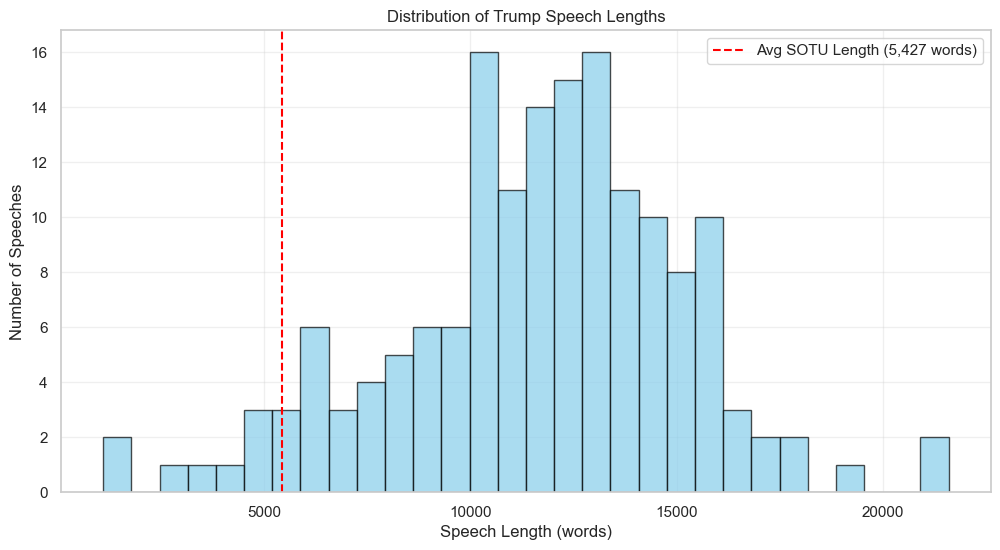

In [14]:
sotu_mean_length = df_sotu['text_length'].mean()

# Plot distribution of speech lengths with SOTU average marked
plt.figure(figsize=(12, 6))
plt.hist(df_speech['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=sotu_mean_length, color='red', linestyle='--', label=f'Avg SOTU Length ({int(sotu_mean_length):,} words)')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Trump Speech Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [15]:
# Calculate percentage of appearances containing each phrase at least once
phrase_percentages = {}
for phrase in SEARCH_PHRASES.keys():
    all_pct = (df[phrase] >= 1).mean() * 100
    speech_pct = (df_speech[phrase] >= 1).mean() * 100
    post_pct = (df_post[phrase] >= 1).mean() * 100
    phrase_percentages[phrase] = {
        'All Appearances': all_pct,
        'Speeches Only': speech_pct, 
        'Post-Inauguration': post_pct
    }

# Create DataFrame and sort by percentage in all appearances
phrase_df = pd.DataFrame.from_dict(phrase_percentages, orient='index')
phrase_df = phrase_df.sort_values('All Appearances', ascending=False)
phrase_df.index.name = 'Phrase'

# Format table for display
styled_df = phrase_df.style.format({
    'All Appearances': '{:.1f}%'.format,
    'Speeches Only': '{:.1f}%'.format,
    'Post-Inauguration': '{:.1f}%'.format
})

print("Percentage of Appearances Containing Each Phrase:")
display(styled_df)


Percentage of Appearances Containing Each Phrase:


,All Appearances,Speeches Only,Post-Inauguration
Phrase,,,
Biden,79.0%,97.5%,65.9%
America,71.4%,98.1%,58.5%
Border,67.2%,98.8%,47.6%
Hell,61.1%,97.5%,43.9%
MAGA,52.7%,91.4%,20.7%
Israel,51.8%,77.8%,29.3%
Rigged,50.1%,86.4%,22.0%
God,46.2%,88.9%,22.0%
Mexico,45.7%,79.0%,30.5%


In [16]:
def create_frequency_comparison(df, df_speech, df_post):
    """Create a comparison table of per-speech frequencies across datasets"""
    results = []
    
    for phrase in SEARCH_PHRASES.keys():
        result = {
            'Phrase': phrase,
            'All Data P(≥1)': (df[phrase] >= 1).mean(),
            'All Speeches P(≥1)': (df_speech[phrase] >= 1).mean(),
            'Post-Inauguration P(≥1)': (df_post[phrase] >= 1).mean(),
            'All Data n': len(df),
            'All Speeches n': len(df_speech),
            'Post-Inauguration n': len(df_post)
        }
        results.append(result)
    
    comparison_df = pd.DataFrame(results)
    
    # Format percentages
    for col in ['All Data P(≥1)', 'All Speeches P(≥1)', 'Post-Inauguration P(≥1)']:
        comparison_df[col] = comparison_df[col].map('{:.1%}'.format)
    
    # Sort by All Data frequency
    comparison_df = comparison_df.sort_values('All Data P(≥1)', ascending=False)
    
    return comparison_df

print("Comparison of Per-Speech Frequencies (P(≥1)):")
comparison_table = create_frequency_comparison(df, df_speech, df_post)
display(comparison_table)

# ... existing code ...

Comparison of Per-Speech Frequencies (P(≥1)):


,Phrase,All Data P(≥1),All Speeches P(≥1),Post-Inauguration P(≥1),All Data n,All Speeches n,Post-Inauguration n
29,Gaza,8.1%,7.4%,23.2%,357,162,82
11,Biden,79.0%,97.5%,65.9%,357,162,82
2,America,71.4%,98.1%,58.5%,357,162,82
3,Border,67.2%,98.8%,47.6%,357,162,82
24,Hell,61.1%,97.5%,43.9%,357,162,82
14,January 6,6.4%,11.7%,2.4%,357,162,82
17,MAGA,52.7%,91.4%,20.7%,357,162,82
23,Israel,51.8%,77.8%,29.3%,357,162,82
20,Rigged,50.1%,86.4%,22.0%,357,162,82
4,DOGE,5.3%,6.2%,18.3%,357,162,82


## Individual Phrase Analysis

In [17]:
# Find speeches shorter than 6000 words with 4+ mentions of MAGA
short_maga_speeches = df[
    (df['text_length'] < 10200) & 
    (df['MAGA'] >= 4)
][['file', 'MAGA']]

print(f"\nSpeeches under 10200 words with 4+ mentions of MAGA:")
print(short_maga_speeches.sort_values('MAGA', ascending=False))


Speeches under 10200 words with 4+ mentions of MAGA:
                                                                                     file  \
166             2024-10-30_donald_trump_holds_a_campaign_rally_in_green_bay_wisconsin.txt   
115            2024-04-02_donald_trump_holds_a_political_rally_in_green_bay_wisconsin.txt   
216  2024-05-31_donald_trump_addresses_his_new_york_felony_convictions_at_trump_tower.txt   
219                 2024-10-11_donald_trump_holds_a_campaign_rally_in_aurora_colorado.txt   
215         2024-01-16_donald_trump_holds_a_political_rally_in_atkinson_new_hampshire.txt   
217          2024-10-25_donald_trump_holds_a_campaign_rally_in_traverse_city_michigan.txt   
86          2025-01-20_donald_trump_holds_a_post-inaugural_rally_at_capitol_one_arena.txt   
167       2024-09-21_donald_trump_holds_a_campaign_rally_in_wilmington_north_carolina.txt   
164            2024-07-13_donald_trump_holds_a_political_rally_in_butler_pennsylvania.txt   
118             

In [18]:
df[df['January 6'] > 0][['file', 'text_length', 'January 6', 'category']]

,file,text_length,January 6,category
103,2024-01-14_donald_trump_holds_a_political_rally_in_indianola_iowa.txt,15943,1,speech
97,2024-01-19_donald_trump_holds_a_political_rally_in_concord_new_hampshire.txt,15275,1,speech
220,2024-01-20_donald_trump_holds_a_political_rally_in_manchester_new_hampshire.txt,14227,1,speech
94,2024-01-22_donald_trump_holds_a_political_rally_in_laconia_new_hampshire.txt,11312,1,speech
179,2024-02-10_donald_trump_holds_a_political_rally_in_conway_south_carolina.txt,15185,1,speech
93,2024-02-14_donald_trump_holds_a_political_rally_in_north_charleston_south_carolina.txt,14710,1,speech
194,2024-02-23_donald_trump_holds_a_political_rally_in_rock_hill_south_carolina.txt,13553,2,speech
85,2024-03-02_donald_trump_holds_a_political_rally_in_richmond_virginia.txt,13998,2,speech
211,2024-03-02_donald_trump_holds_a_political_rally_in_greensboro_north_carolina.txt,11588,2,speech
162,2024-03-09_donald_trump_holds_a_political_rally_in_rome_georgia.txt,17035,1,speech


In [19]:
df[df['LA'] > 0][['file', 'text_length', 'LA', 'category']].sort_values('file')

,file,text_length,LA,category
203,2023-09-29_donald_trump_addresses_a_california_gop_lunch_event_in_anaheim.txt,15552,4,speech
233,2023-10-01_donald_trump_holds_a_campaign_event_in_ottumwa_iowa.txt,13209,1,speech
96,2023-10-07_donald_trump_holds_a_campaign_rally_in_waterloo_iowa.txt,10179,1,speech
136,2023-10-11_donald_trump_addresses_his_club_47_fan_club_in_west_palm_beach_florida.txt,17529,1,speech
190,2023-12-17_donald_trump_holds_a_political_rally_in_reno_nevada.txt,10979,1,speech
114,2024-01-05_donald_trump_holds_a_campaign_rally_in_sioux_center_iowa.txt,19189,2,speech
146,2024-01-06_donald_trump_holds_a_campaign_event_in_clinton_iowa.txt,11001,1,speech
97,2024-01-19_donald_trump_holds_a_political_rally_in_concord_new_hampshire.txt,15275,1,speech
232,2024-01-21_donald_trump_holds_a_political_rally_in_rochester_new_hampshire.txt,13102,2,speech
94,2024-01-22_donald_trump_holds_a_political_rally_in_laconia_new_hampshire.txt,11312,1,speech


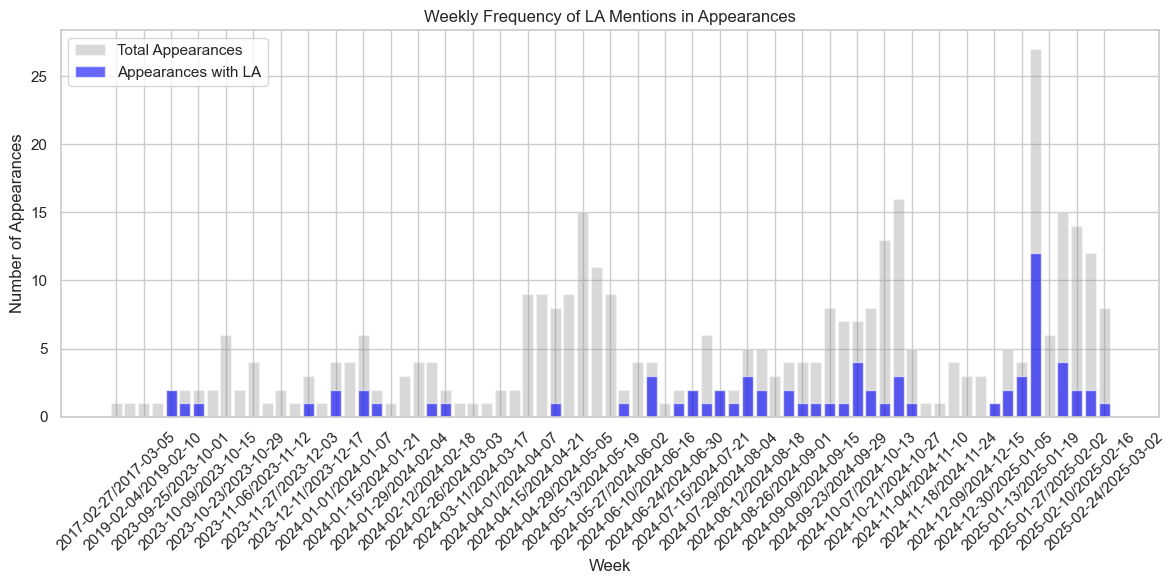

In [20]:
# Convert date strings to datetime 
df['date'] = pd.to_datetime(df['date'])

# Create weekly bins
df['week'] = df['date'].dt.to_period('W')

# Group by week and calculate metrics
weekly_stats = df.groupby('week').agg({
    'file': 'count',  # Total speeches per week
    'LA': lambda x: (x > 0).sum()  # Speeches containing LA per week
}).reset_index()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for speech counts
ax.bar(range(len(weekly_stats)), weekly_stats['file'], alpha=0.3, color='gray', label='Total Appearances')
ax.bar(range(len(weekly_stats)), weekly_stats['LA'], alpha=0.6, color='blue', label='Appearances with LA')

# Customize axes
ax.set_xlabel('Week')
ax.set_ylabel('Number of Appearances')

# Set x-axis ticks to show dates every 2 weeks
tick_indices = range(0, len(weekly_stats), 2)
plt.xticks(tick_indices, [str(weekly_stats['week'].iloc[i]) for i in tick_indices], rotation=45)

# Add legend
ax.legend(loc='upper left')

plt.title('Weekly Frequency of LA Mentions in Appearances')
plt.tight_layout()
plt.show()
